<a href="https://www.kaggle.com/code/mohammedmohsen0404/english-french-nmt-with-attention?scriptVersionId=198314223" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

---
**<center><h1>English-French NMT with Attention</h1></center>**
<center><h3>Learning ML, DL through 100 Practical Projects</h3></center>

---

The aim of this project is to build a Neural Machine Translation (NMT) model using a sequence-to-sequence (seq2seq) architecture with LSTM layers and an attention mechanism to translate English sentences into French. The attention mechanism is integrated to enhance the model's ability to focus on specific parts of the input sentence, leading to more accurate and contextually appropriate translations.

![Luing_vs_Bahdanau](https://miro.medium.com/max/1000/1*BfwFEH4tgY-JwHxr-2D2KQ.png)


# **Import Libraries and Data**
---

In [1]:
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
from sklearn.model_selection import train_test_split

from keras.layers import Input, LSTM, Embedding, Dense, Bidirectional, Concatenate, Dot, Activation, TimeDistributed
from keras.models import Model
from keras.utils import plot_model

In [2]:
!wget http://www.manythings.org/anki/fra-eng.zip
!unzip fra-eng.zip -d fra-eng

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-09-26 03:50:58--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7943074 (7.6M) [application/zip]
Saving to: 'fra-eng.zip'

fra-eng.zip         100%[===================>]   7.57M  20.1MB/s    in 0.4s    

2024-09-26 03:50:59 (20.1 MB/s) - 'fra-eng.zip' saved [7943074/7943074]

Archive:  fra-eng.zip
  inflating: fra-eng/_about.txt      
  inflating: fra-eng/fra.txt         


# **Data Preparing**
---

In [3]:
data_path = 'fra-eng/fra.txt'
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

lines[:5]

['Go.\tVa !\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)',
 'Go.\tMarche.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8090732 (Micsmithel)',
 'Go.\tEn route !\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8267435 (felix63)',
 'Go.\tBouge !\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #9022935 (Micsmithel)',
 'Hi.\tSalut !\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #509819 (Aiji)']

In [4]:
inputs = []
targets = []
num_samples = 10000  # Number of samples to train on.
for line in lines[: min(num_samples, len(lines) - 1)]:
  input, target, _ = line.split('\t')
  inputs.append(input)
  targets.append(target)

print(inputs [:5])
print(targets[:5])

['Go.', 'Go.', 'Go.', 'Go.', 'Hi.']
['Va !', 'Marche.', 'En route !', 'Bouge !', 'Salut !']


In [5]:
lines = pd.DataFrame({'input':inputs, 'target':targets})
num_samples = 10000
lines = lines[0:num_samples]
lines.shape

(10000, 2)

In [6]:
lines.head(10)

,input,target
0,Go.,Va !
1,Go.,Marche.
2,Go.,En route !
3,Go.,Bouge !
4,Hi.,Salut !
5,Hi.,Salut.
6,Run!,Cours !
7,Run!,Courez !
8,Run!,Prenez vos jambes à vos cous !
9,Run!,File !


In [7]:
def cleanup(lines):
  # Since we work on word level, if we normalize the text to lower case, this will reduce the vocabulary. It's easy to recover the case later.
  lines.input=lines.input.apply(lambda x: x.lower())
  lines.target=lines.target.apply(lambda x: x.lower())

  # To help the model capture the word separations, mark the comma with special token:
  lines.input=lines.input.apply(lambda x: re.sub("'", '', x)).apply(lambda x: re.sub(",", ' COMMA', x))
  lines.target=lines.target.apply(lambda x: re.sub("'", '', x)).apply(lambda x: re.sub(",", ' COMMA', x))

  # Clean up punctuations and digits. Such special chars are common to both domains, and can just be copied with no error.
  exclude = set(string.punctuation)
  lines.input=lines.input.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
  lines.target=lines.target.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

  remove_digits = str.maketrans('', '', digits)
  lines.input=lines.input.apply(lambda x: x.translate(remove_digits))
  lines.target=lines.target.apply(lambda x: x.translate(remove_digits))

  #return lines


In [8]:
st_tok = 'START_'
end_tok = '_END'
def data_prep(lines):
  cleanup(lines)
  lines.target = lines.target.apply(lambda x : st_tok + ' ' + x + ' ' + end_tok)

In [9]:
data_prep(lines)
lines.head(20)

,input,target
0,go,START_ va _END
1,go,START_ marche _END
2,go,START_ en route _END
3,go,START_ bouge _END
4,hi,START_ salut _END
5,hi,START_ salut _END
6,run,START_ cours _END
7,run,START_ courez _END
8,run,START_ prenez vos jambes à vos cous _END
9,run,START_ file _END


# **Data Preprocessing**
--------

**Tokenization**

In [10]:
def tok_split_word2word(data):
    return data.split()

def data_stats(lines, input_tok_split_fn, target_tok_split_fn):
    # Get unique tokens using set comprehensions
    input_tokens = set(tok for line in lines.input for tok in input_tok_split_fn(line))
    target_tokens = set(tok for line in lines.target for tok in target_tok_split_fn(line))

    # Convert to sorted lists
    input_tokens = sorted(input_tokens)
    target_tokens = sorted(target_tokens)

    # Calculate lengths
    num_encoder_tokens = len(input_tokens)
    num_decoder_tokens = len(target_tokens)
    max_encoder_seq_length = max(len(input_tok_split_fn(line)) for line in lines.input)
    max_decoder_seq_length = max(len(target_tok_split_fn(line)) for line in lines.target)

    return (input_tokens, target_tokens, num_encoder_tokens,num_decoder_tokens, max_encoder_seq_length, max_decoder_seq_length)

In [11]:
input_tokens, target_tokens, num_encoder_tokens, num_decoder_tokens, max_encoder_seq_length, max_decoder_seq_length = data_stats(
    lines, input_tok_split_fn=tok_split_word2word, target_tok_split_fn=tok_split_word2word)

print('Number of samples:', len(lines))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 2022
Number of unique output tokens: 4412
Max sequence length for inputs: 5
Max sequence length for outputs: 12


**Vocab**

In [12]:
pad_tok = 'PAD'
sep_tok = ' '
special_tokens = [pad_tok, sep_tok, st_tok, end_tok]
num_encoder_tokens += len(special_tokens)
num_decoder_tokens += len(special_tokens)

In [13]:
def vocab(input_tokens, target_tokens):

  input_token_index = {}
  target_token_index = {}
  for i,tok in enumerate(special_tokens):
    input_token_index[tok] = i
    target_token_index[tok] = i

  offset = len(special_tokens)
  for i, tok in enumerate(input_tokens):
    input_token_index[tok] = i+offset

  for i, tok in enumerate(target_tokens):
    target_token_index[tok] = i+offset

  # Reverse-lookup token index to decode sequences back to something readable.
  reverse_input_tok_index = dict(
      (i, tok) for tok, i in input_token_index.items())
  reverse_target_tok_index = dict(
      (i, tok) for tok, i in target_token_index.items())
  return input_token_index, target_token_index, reverse_input_tok_index, reverse_target_tok_index

In [14]:
input_token_index, target_token_index, reverse_input_tok_index, reverse_target_tok_index = vocab(input_tokens, target_tokens)

**Vectorization**

In [15]:
max_encoder_seq_length = 16
max_decoder_seq_length = 16

In [16]:
def init_model_inputs(lines, max_encoder_seq_length, max_decoder_seq_length, num_decoder_tokens):
  encoder_input_data = np.zeros(
      (len(lines.input), max_encoder_seq_length),
      dtype='float32')
  decoder_input_data = np.zeros(
      (len(lines.target), max_decoder_seq_length),
      dtype='float32')
  decoder_target_data = np.zeros(
      (len(lines.target), max_decoder_seq_length, num_decoder_tokens),
      dtype='float32')

  return encoder_input_data, decoder_input_data, decoder_target_data

In [17]:
def vectorize(lines, max_encoder_seq_length, max_decoder_seq_length, num_decoder_tokens, input_tok_split_fn, target_tok_split_fn):
  encoder_input_data, decoder_input_data, decoder_target_data = init_model_inputs(lines, max_encoder_seq_length, max_decoder_seq_length, num_decoder_tokens)
  for i, (input_text, target_text) in enumerate(zip(lines.input, lines.target)):
      for t, tok in enumerate(input_tok_split_fn(input_text)):
          encoder_input_data[i, t] = input_token_index[tok]
      encoder_input_data[i, t+1:] = input_token_index[pad_tok]
      for t, tok in enumerate(target_tok_split_fn(target_text)):
          # decoder_target_data is ahead of decoder_input_data by one timestep
          decoder_input_data[i, t] = target_token_index[tok]
          if t > 0:
              # decoder_target_data will be ahead by one timestep
              # and will not include the start character.
              decoder_target_data[i, t - 1, target_token_index[tok]] = 1.
      decoder_input_data[i, t+1:] = target_token_index[pad_tok]
      decoder_target_data[i, t:, target_token_index[pad_tok]] = 1.

  return encoder_input_data, decoder_input_data, decoder_target_data

In [18]:
encoder_input_data, decoder_input_data, decoder_target_data  = vectorize(lines, max_encoder_seq_length, max_decoder_seq_length, num_decoder_tokens, input_tok_split_fn=tok_split_word2word, target_tok_split_fn=tok_split_word2word)

In [19]:
encoder_input_data.shape, decoder_input_data.shape, decoder_target_data.shape

((10000, 16), (10000, 16), (10000, 16, 4416))

# **Modelling**

In [20]:
def seq2seq_attention(num_encoder_tokens, num_decoder_tokens, emb_sz, latent_dim):
    # Define an input sequence and process it.
    encoder_inputs = Input(shape=(None,), dtype='float32')
    encoder_inputs_ = Embedding(num_encoder_tokens, emb_sz, mask_zero=True)(encoder_inputs)

    encoder = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True)) # Bi LSTM
    encoder_outputs, state_f_h, state_f_c, state_b_h, state_b_c = encoder(encoder_inputs_)# Bi LSTM
    state_h = Concatenate()([state_f_h, state_b_h])# Bi LSTM
    state_c = Concatenate()([state_f_c, state_b_c])# Bi LSTM

    # We discard `encoder_outputs` and only keep the states.
    encoder_states = [state_h, state_c]# Bi GRU, LSTM, BHi LSTM
    print(encoder_states)

    decoder_inputs = Input(shape=(None,))
    decoder_inputs_ = Embedding(num_decoder_tokens, emb_sz, mask_zero=True)(decoder_inputs)
    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the
    # return states in the training model, but we will use them in inference.
    decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True)# Bi LSTM

    decoder_outputs, _, _ = decoder_lstm(decoder_inputs_, initial_state=encoder_states)

    # Equation (7) with 'dot' score from Section 3.1 in the paper.
    # Note that we reuse Softmax-activation layer instead of writing tensor calculation
    print(decoder_outputs)
    print(encoder_outputs)
    att_dot = Dot(axes=[2, 2])
    attention = att_dot([decoder_outputs, encoder_outputs])
    att_activation = Activation('softmax', name='attention')
    attention = att_activation(attention)
    print('attention', attention)
    context_dot = Dot(axes=[2,1])
    context = context_dot([attention, encoder_outputs])
    att_context_concat = Concatenate()
    decoder_combined_context = att_context_concat([context, decoder_outputs])

    # Has another weight + tanh layer as described in equation (5) of the paper

    decoder_dense = Dense(num_decoder_tokens, activation='softmax')
    #decoder_outputs = decoder_dense(decoder_outputs)
    decoder_outputs = decoder_dense(decoder_combined_context)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

    print('encoder-decoder  model:')
    print(model.summary())

    print(encoder_inputs)
    print(encoder_outputs)
    print(encoder_states)
    encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs] + encoder_states)

    decoder_encoder_inputs = Input(shape=(None, latent_dim*2,))
    decoder_state_input_h = Input(shape=(latent_dim*2,))# Bi LSTM
    decoder_state_input_c = Input(shape=(latent_dim*2,)) # Bi LSTM

    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_, initial_state=decoder_states_inputs)


    decoder_states = [state_h, state_c]

    # Equation (7) with 'dot' score from Section 3.1 in the paper.
    # Note that we reuse Softmax-activation layer instead of writing tensor calculation

    attention = att_dot([decoder_outputs, decoder_encoder_inputs])

    attention = att_activation(attention)

    context = context_dot([attention, decoder_encoder_inputs])



    decoder_combined_context = att_context_concat([context, decoder_outputs])

    # Has another weight + tanh layer as described in equation (5) of the paper

    decoder_outputs = decoder_dense(decoder_combined_context)

    decoder_model = Model(
        [decoder_inputs, decoder_encoder_inputs] + decoder_states_inputs,
        [decoder_outputs, attention] + decoder_states)

    return model, encoder_model, decoder_model

[<KerasTensor shape=(None, 512), dtype=float32, sparse=False, name=keras_tensor_8>, <KerasTensor shape=(None, 512), dtype=float32, sparse=False, name=keras_tensor_9>]
<KerasTensor shape=(None, None, 512), dtype=float32, sparse=False, name=keras_tensor_13>
<KerasTensor shape=(None, None, 512), dtype=float32, sparse=False, name=keras_tensor_3>
attention <KerasTensor shape=(None, None, None), dtype=float32, sparse=False, name=keras_tensor_17>
encoder-decoder  model:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 256) │    518,656 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None)      │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ [(None, None,     │  1,050,624 │ embedding[0][0],  │
│ (Bidirectional)     │ 512), (None,      │            │ not_equal[0][0]   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 256) │  1,130,496 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 512)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 512)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, None,     │  1,574,912 │ embedding_1[0][0… │
│                     │ 512), (None,      │            │ concatenate[0][0… │
│                     │ 512), (None,      │            │ concatenate_1[0]… │
│                     │ 512)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, None,      │          0 │ lstm_1[0][0],     │
│                     │ None)             │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, None,      │          0 │ dot[0][0]         │
│ (Activation)        │ None)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_1 (Dot)         │ (None, None, 512) │          0 │ attention[0][0],  │
│                     │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, None,      │          0 │ dot_1[0][0],      │
│ (Concatenate)       │ 1024)             │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None,      │  4,526,400 │ concatenate_2[0]… │
│                     │ 4416)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,801,088 (33.57 MB)

 Trainable params: 8,801,088 (33.57 MB)

 Non-trainable params: 0 (0.00 B)

None
<KerasTensor shape=(None, None), dtype=float32, sparse=None, name=keras_tensor>
<KerasTensor shape=(None, None, 512), dtype=float32, sparse=False, name=keras_tensor_3>
[<KerasTensor shape=(None, 512), dtype=float32, sparse=False, name=keras_tensor_8>, <KerasTensor shape=(None, 512), dtype=float32, sparse=False, name=keras_tensor_9>]


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 256) │    518,656 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None)      │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ [(None, None,     │  1,050,624 │ embedding[0][0],  │
│ (Bidirectional)     │ 512), (None,      │            │ not_equal[0][0]   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 256) │  1,130,496 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 512)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 512)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, None,     │  1,574,912 │ embedding_1[0][0… │
│                     │ 512), (None,      │            │ concatenate[0][0… │
│                     │ 512), (None,      │            │ concatenate_1[0]… │
│                     │ 512)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, None,      │          0 │ lstm_1[0][0],     │
│                     │ None)             │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, None,      │          0 │ dot[0][0]         │
│ (Activation)        │ None)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_1 (Dot)         │ (None, None, 512) │          0 │ attention[0][0],  │
│                     │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, None,      │          0 │ dot_1[0][0],      │
│ (Concatenate)       │ 1024)             │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None,      │  4,526,400 │ concatenate_2[0]… │
│                     │ 4416)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,801,088 (33.57 MB)

 Trainable params: 8,801,088 (33.57 MB)

 Non-trainable params: 0 (0.00 B)

None


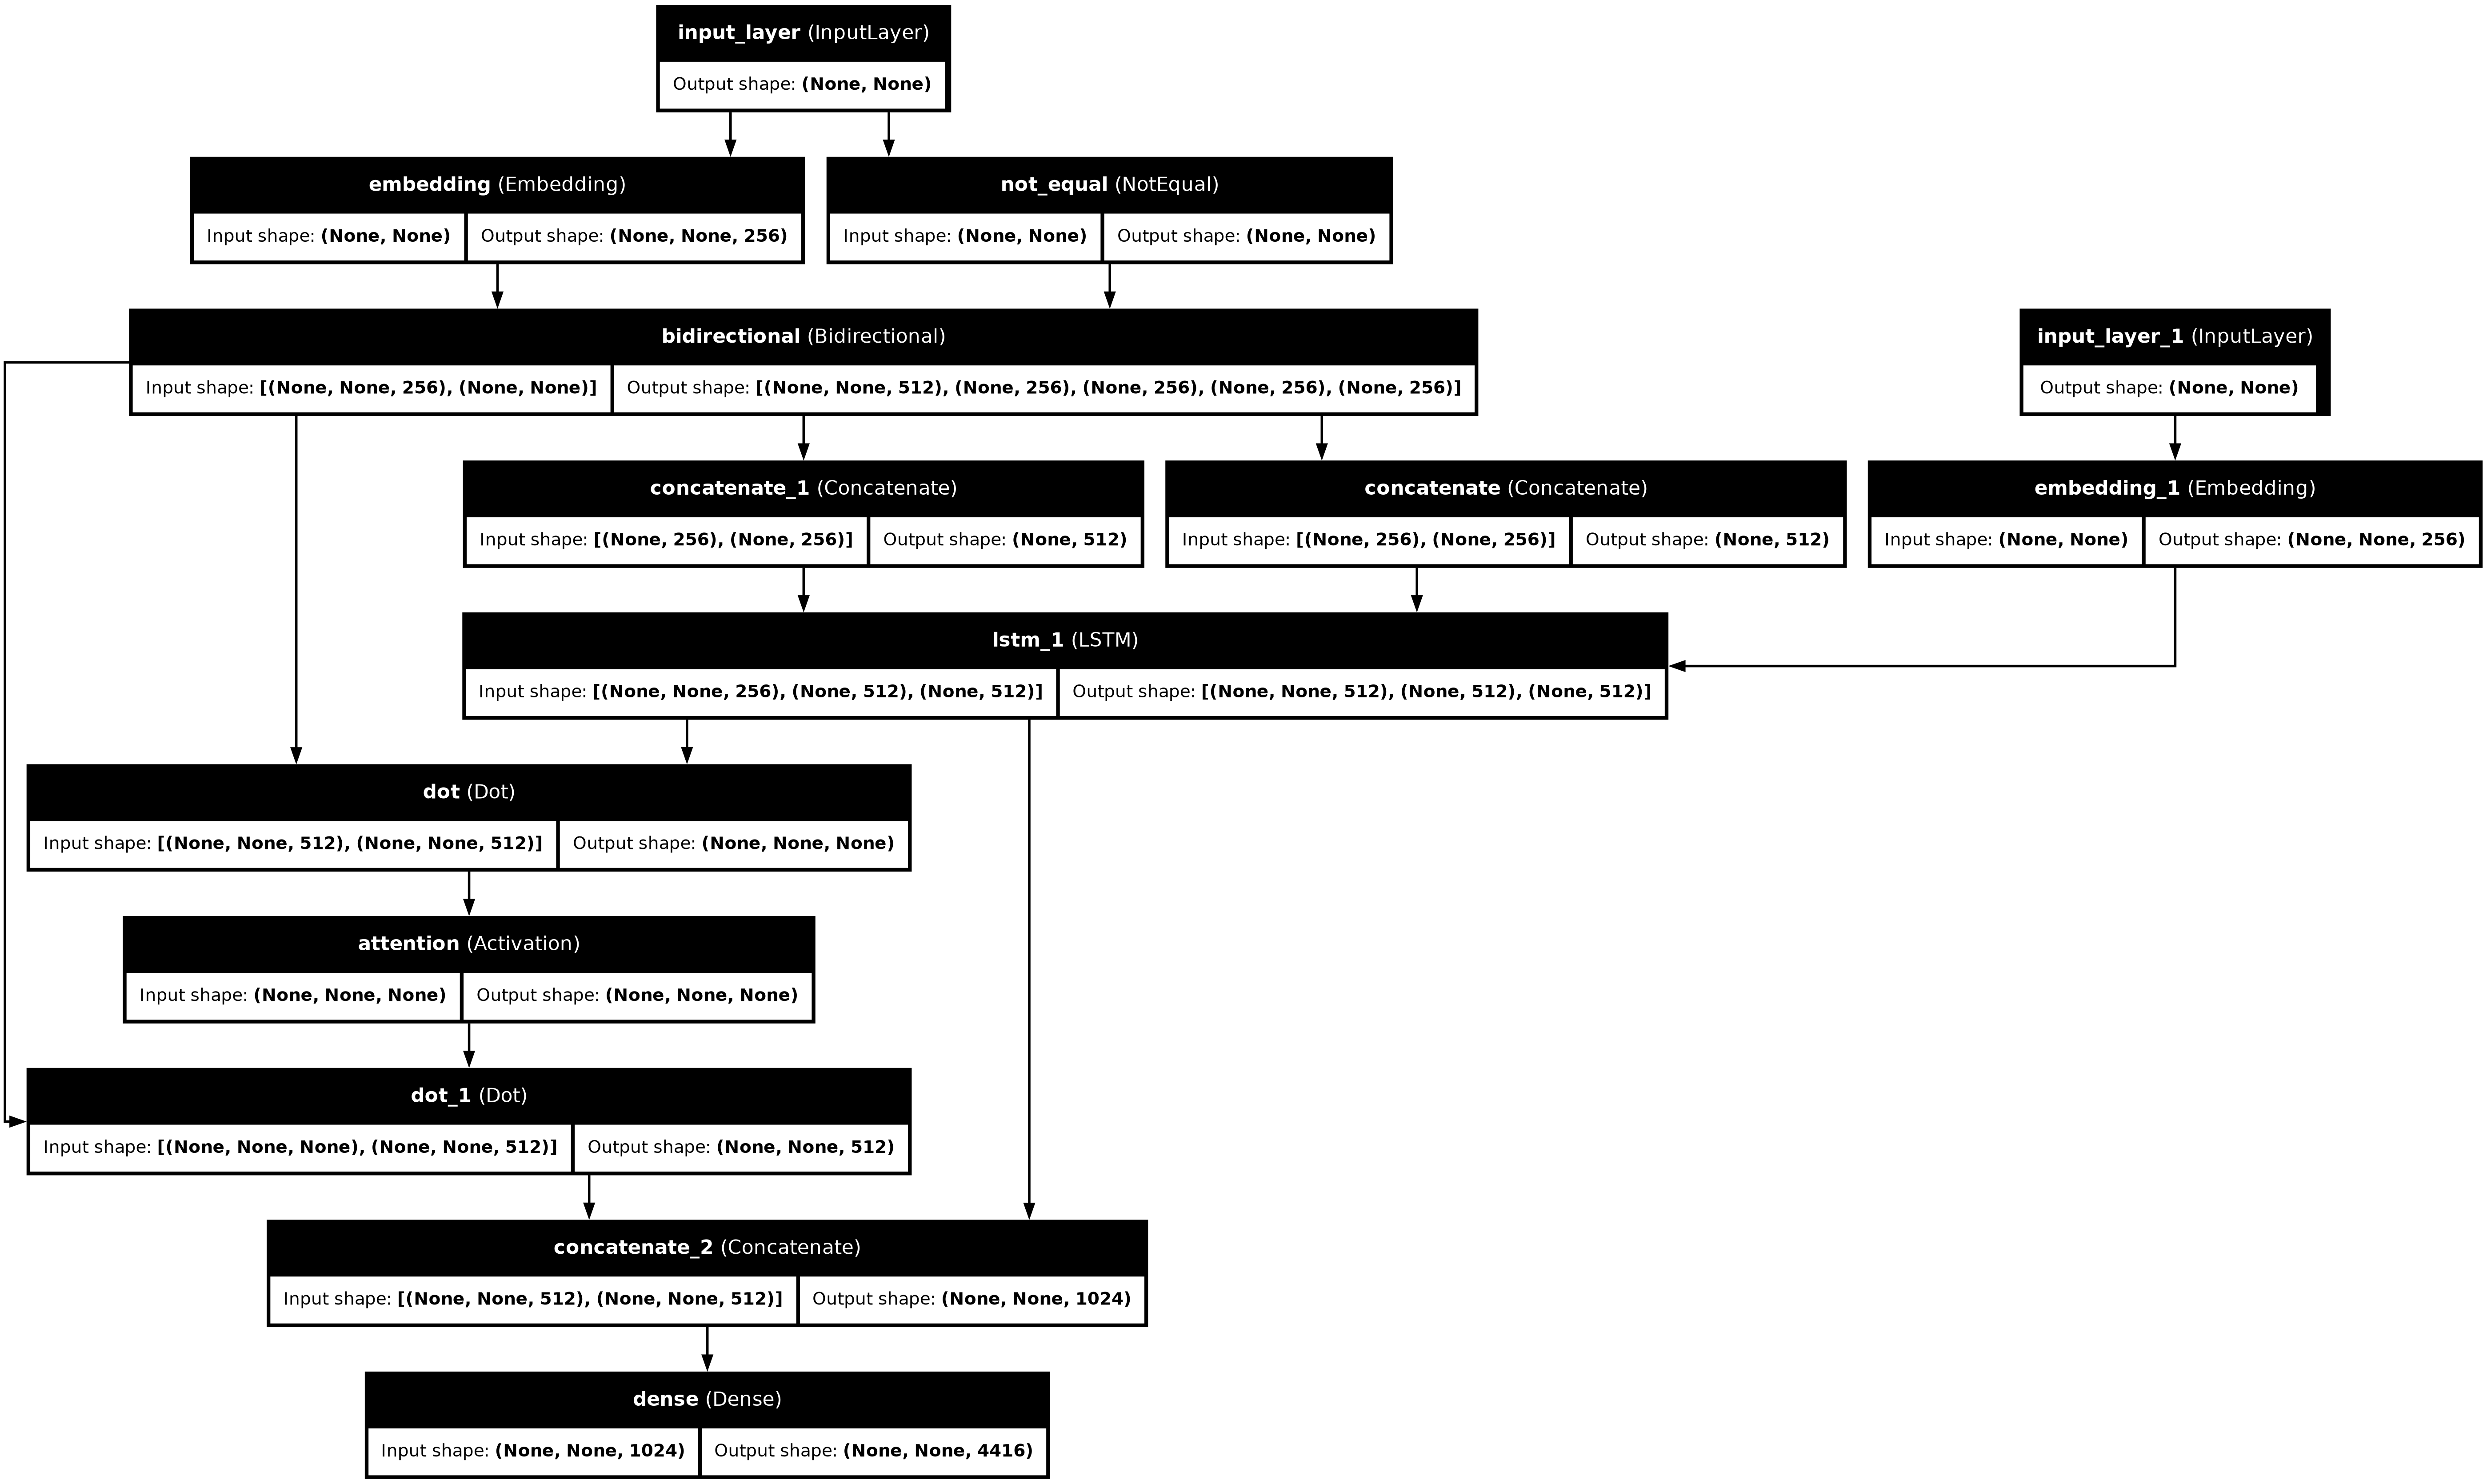

In [21]:
emb_sz = 256
model, encoder_model, decoder_model = seq2seq_attention(num_encoder_tokens, num_decoder_tokens, emb_sz=emb_sz, latent_dim=emb_sz)
print(model.summary())
plot_model(model, show_shapes=True, show_layer_names=True)

In [22]:
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=128,
          epochs=20,
          validation_split=0.05)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - acc: 0.7067 - loss: 3.1918 - val_acc: 0.7771 - val_loss: 1.5527
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - acc: 0.8226 - loss: 1.2941 - val_acc: 0.7771 - val_loss: 1.4473
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - acc: 0.8272 - loss: 1.2239 - val_acc: 0.7771 - val_loss: 1.4193
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - acc: 0.8287 - loss: 1.2002 - val_acc: 0.7870 - val_loss: 1.3789
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - acc: 0.8320 - loss: 1.1697 - val_acc: 0.7940 - val_loss: 1.3821
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - acc: 0.8347 - loss: 1.1501 - val_acc: 0.8111 - val_loss: 1.3588
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - acc: 0.8348 - loss: 1.1322 - val_acc: 0.8111 - val_loss: 1.3302
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - acc: 0.8391 - loss: 1.1029 - val_acc: 0.8220 - val_loss: 1.2903
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - acc: 0.83

# **Inference**
---

In [23]:
def decode_sequence_attention(input_seq, sep=' '):
    # Encode the input as state vectors.
    encoder_outputs, h, c = encoder_model.predict(input_seq)
    states_value = [h,c]
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index[st_tok]

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    attention_density = []
    while not stop_condition:
        output_tokens, attention, h, c  = decoder_model.predict(
            [target_seq, encoder_outputs] + states_value)
        attention_density.append(attention[0][0])# attention is max_sent_len x 1 since we have num_time_steps = 1 for the output
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_tok = reverse_target_tok_index[sampled_token_index]
        decoded_sentence += sep + sampled_tok

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_tok == end_tok or
           len(decoded_sentence) > 52):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]
    attention_density = np.array(attention_density)
    return decoded_sentence, attention_density

#### Look at the some translations

In [24]:
word_decoded_sents = []
for seq_index in range(15):
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence, attention = decode_sequence_attention(input_seq)
    print('-')
    print('Input sentence:', lines.input[seq_index: seq_index + 1])
    print('Decoded sentence:', decoded_sentence)
    word_decoded_sents.append(decoded_sentence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
-
Input sentence: 0    go
Name: input, dtype: object
Decoded sentence:  vous êtes en train _END
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
-
Input sentence: 1    go
Name: input, dtype: object
Decoded sentence:  vous êtes en train _END
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
-
Input sentence: 2    go
Name: input, dtype: object
Decoded sentence:  vous êtes en train _END
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

In [25]:
def visualize_attention(text, encoder_model, decoder_model, max_encoder_seq_length, num_decoder_tokens, vocab_to_int, int_to_vocab, tok_split_fn, sep= ' '):

    encoder_input_data = np.zeros((1, max_encoder_seq_length), dtype='float32')

    for t, word in enumerate(tok_split_fn(text)):
        encoder_input_data[0, t] = input_token_index[word]

    input_seq = encoder_input_data[0:1]

    decoded_sentence, attention_density = decode_sequence_attention(input_seq, sep)

    plt.clf()
    plt.figure(figsize=(28,12))

    ax = sns.heatmap(attention_density[:, : len(text) + 2],
        xticklabels=[w for w in tok_split_fn(text)],
        yticklabels=[w for w in tok_split_fn(decoded_sentence)])

    ax.invert_yaxis()
    plt.show()

    return decoded_sentence

-
Input sentence: go
GT sentence: START_ va  _END
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


<Figure size 640x480 with 0 Axes>

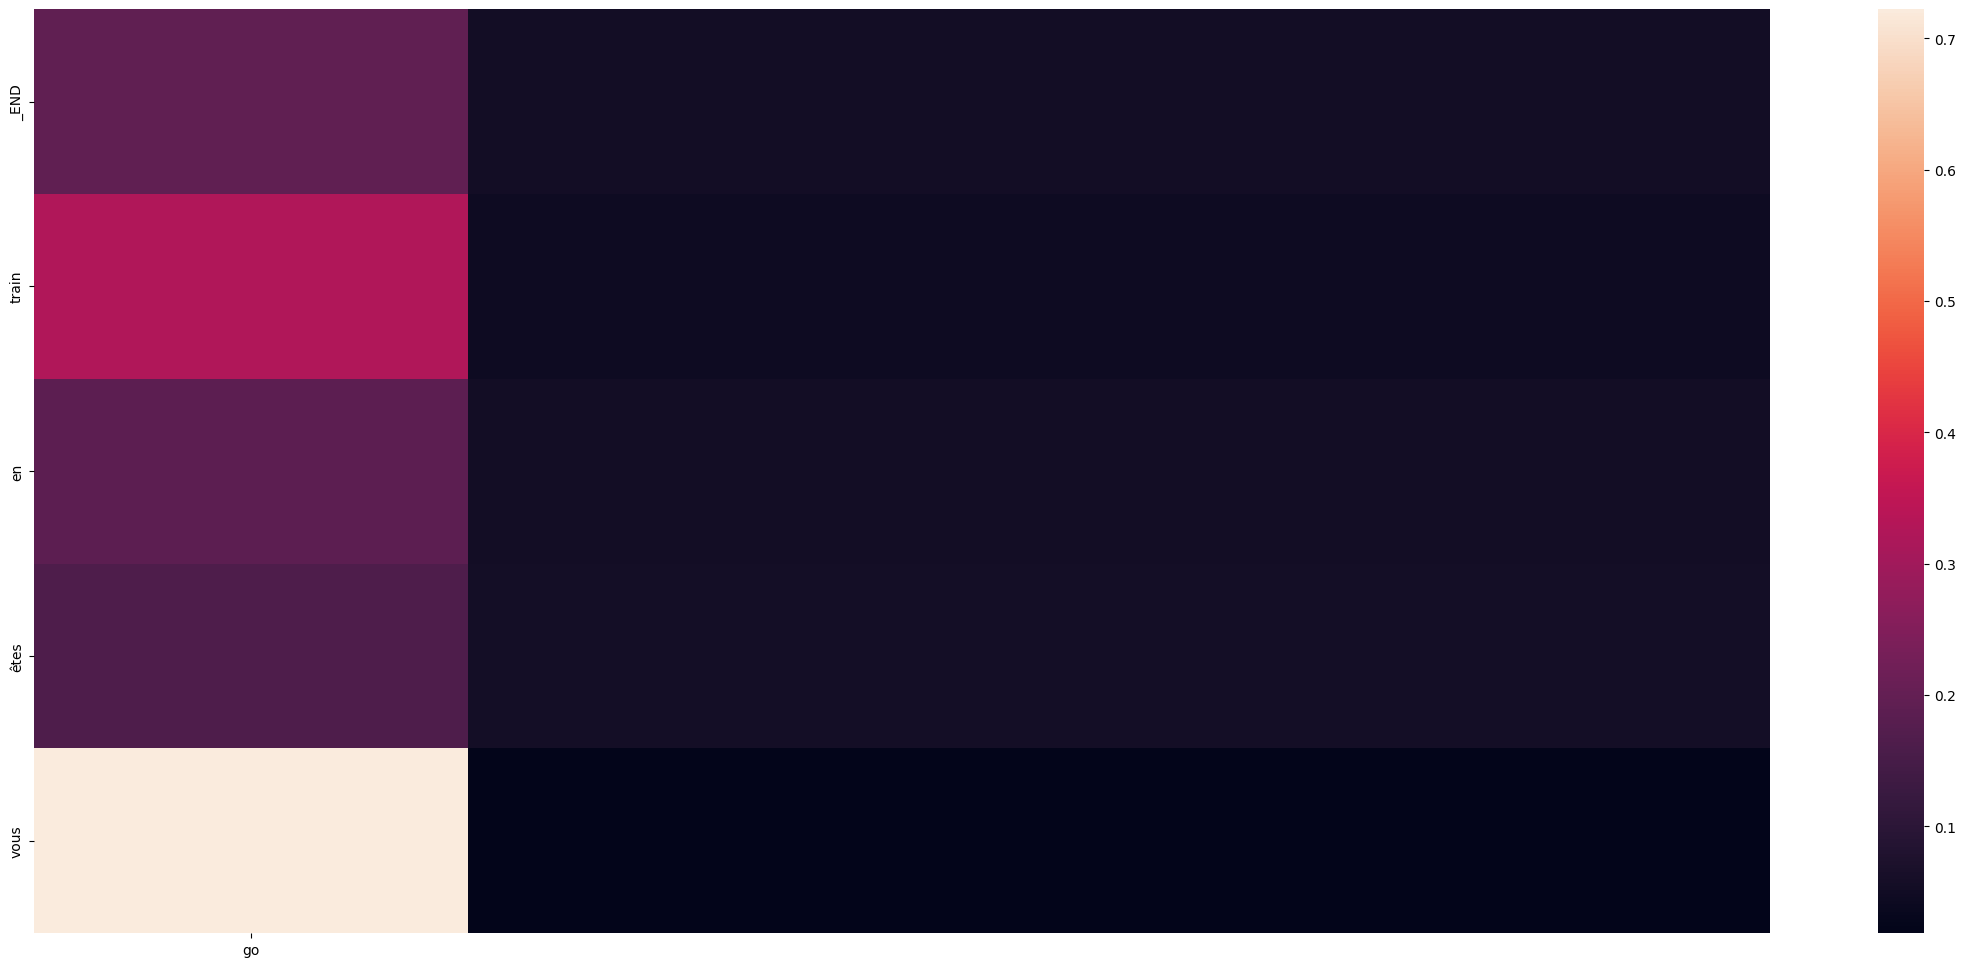

Decoded sentence:  vous êtes en train _END
-
Input sentence: go
GT sentence: START_ marche _END
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


<Figure size 640x480 with 0 Axes>

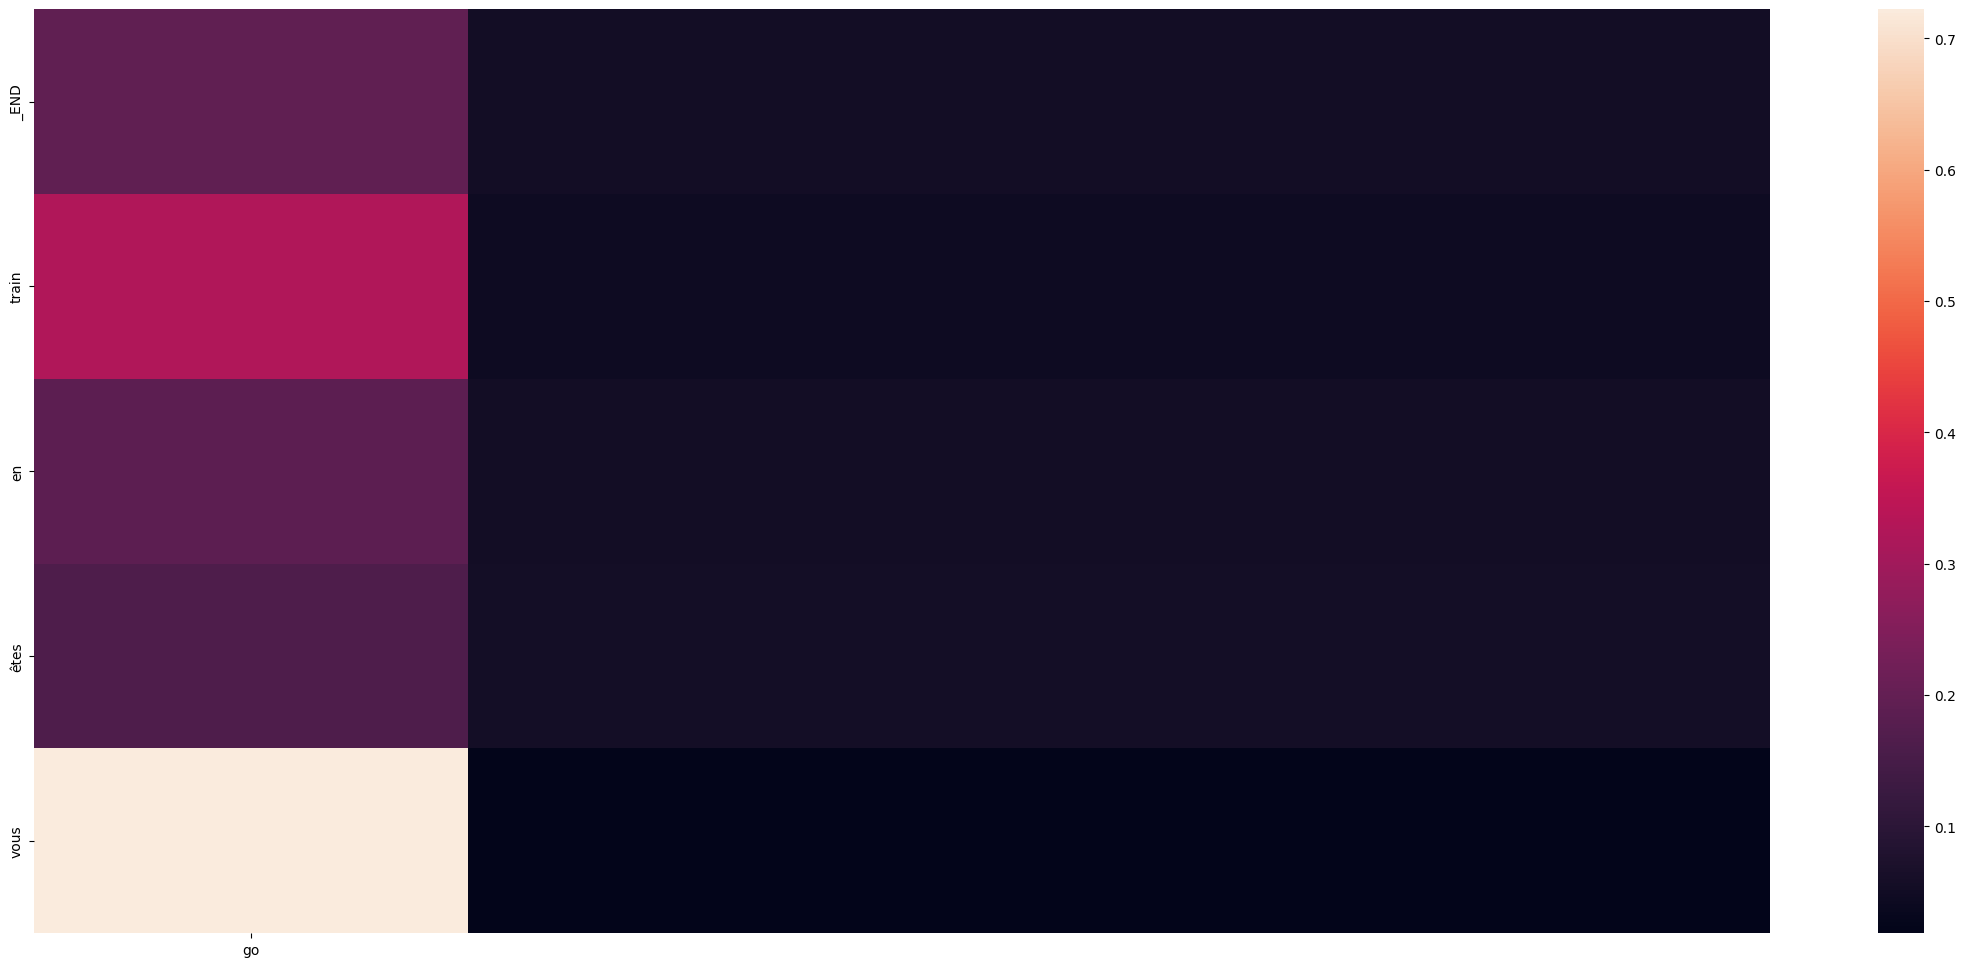

Decoded sentence:  vous êtes en train _END
-
Input sentence: go
GT sentence: START_ en route  _END
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


<Figure size 640x480 with 0 Axes>

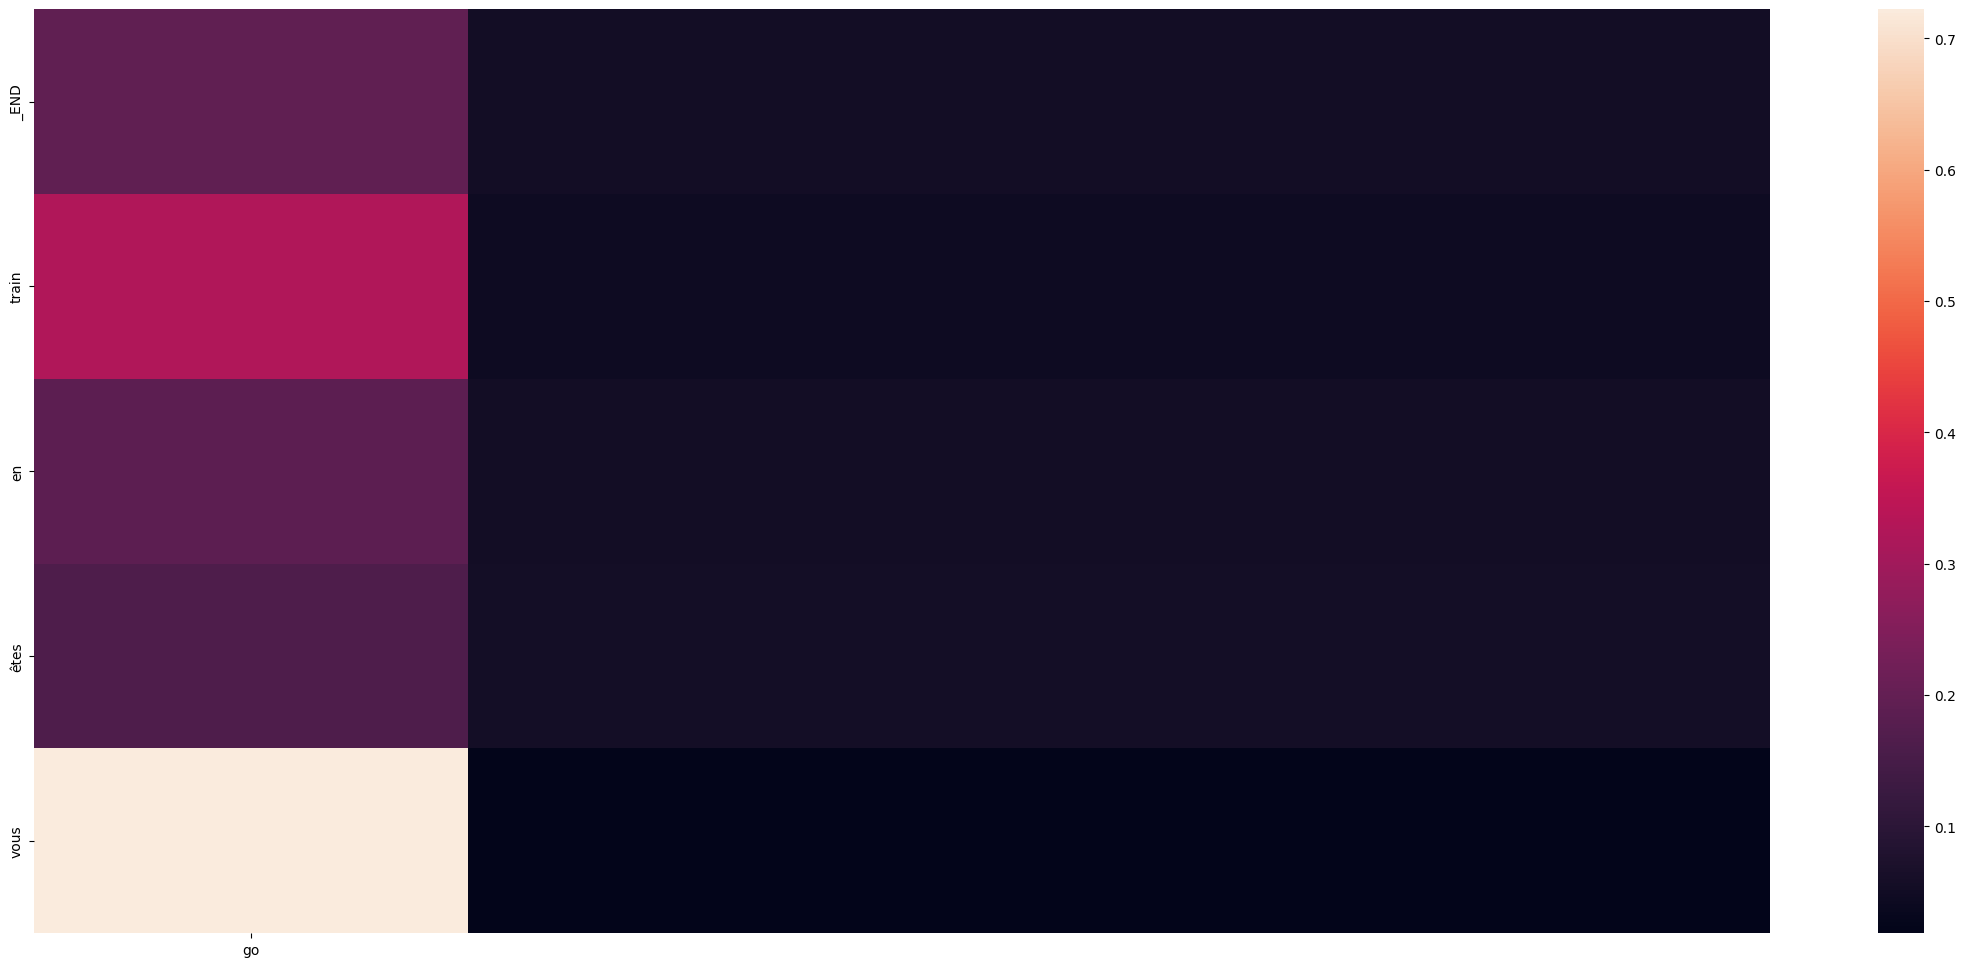

Decoded sentence:  vous êtes en train _END
-
Input sentence: go
GT sentence: START_ bouge  _END
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


<Figure size 640x480 with 0 Axes>

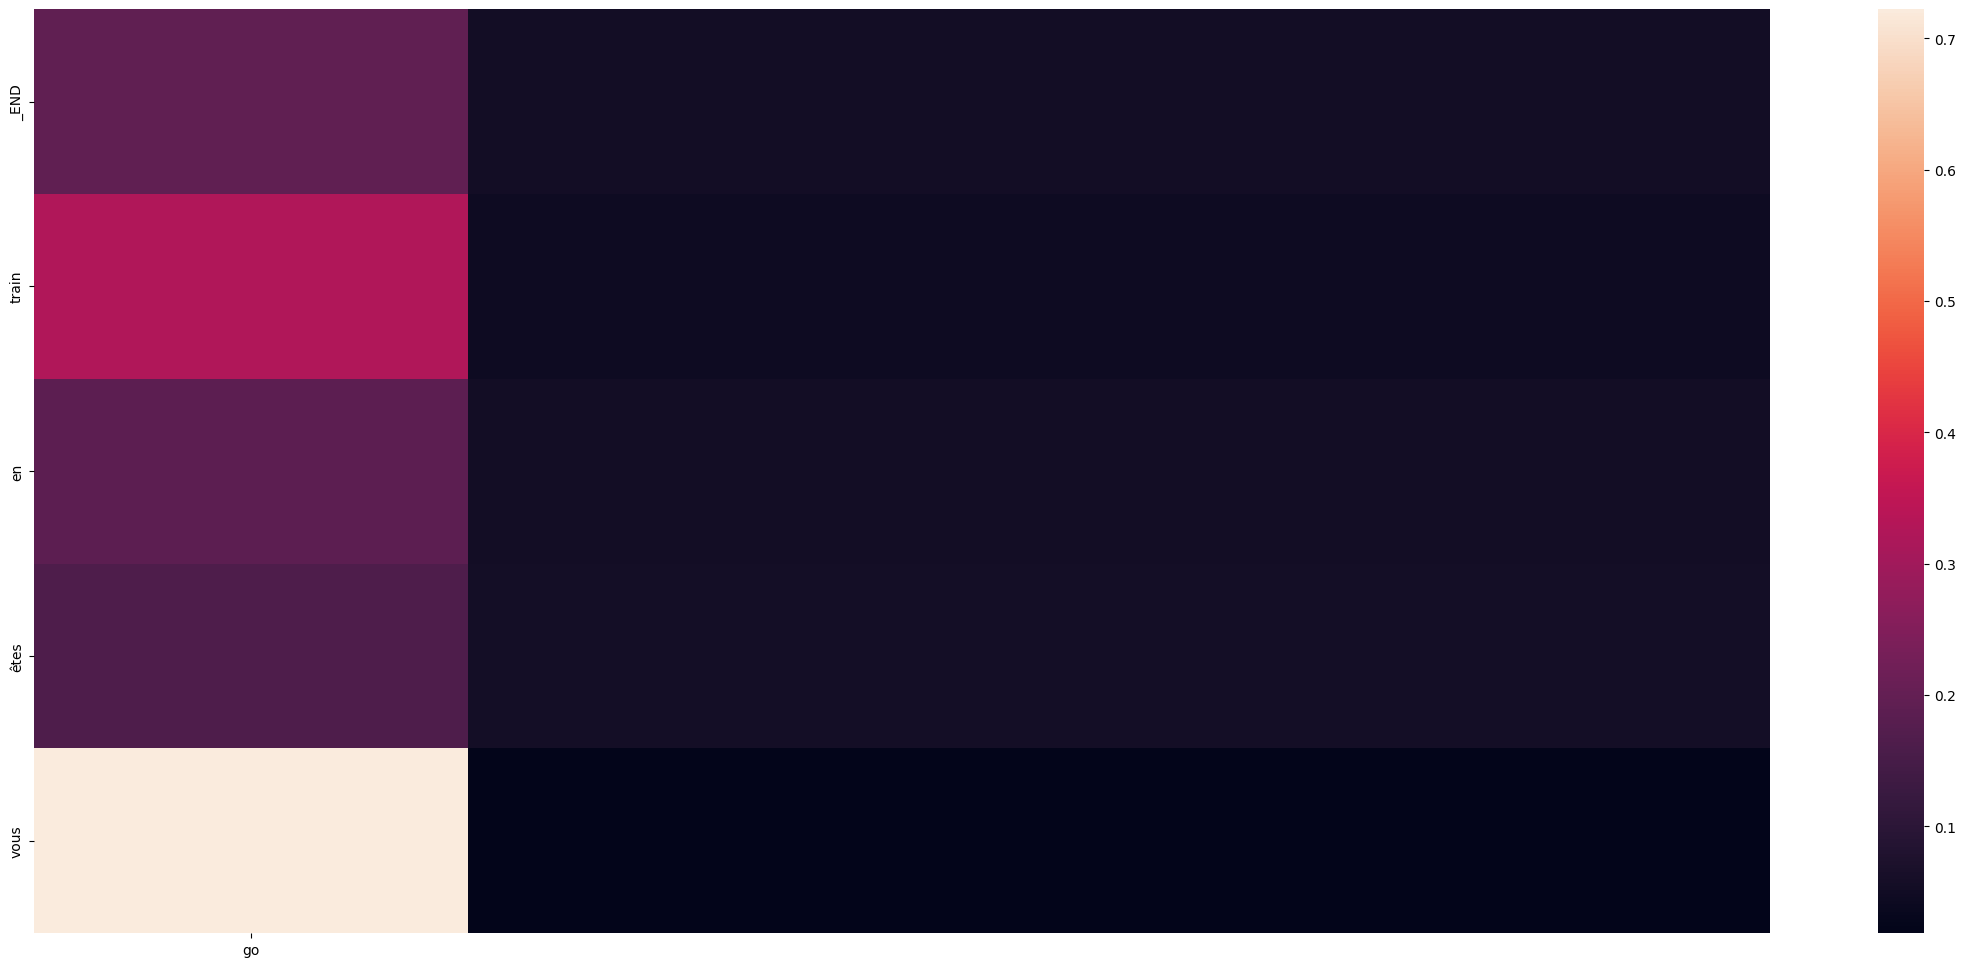

Decoded sentence:  vous êtes en train _END
-
Input sentence: hi
GT sentence: START_ salut  _END
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


<Figure size 640x480 with 0 Axes>

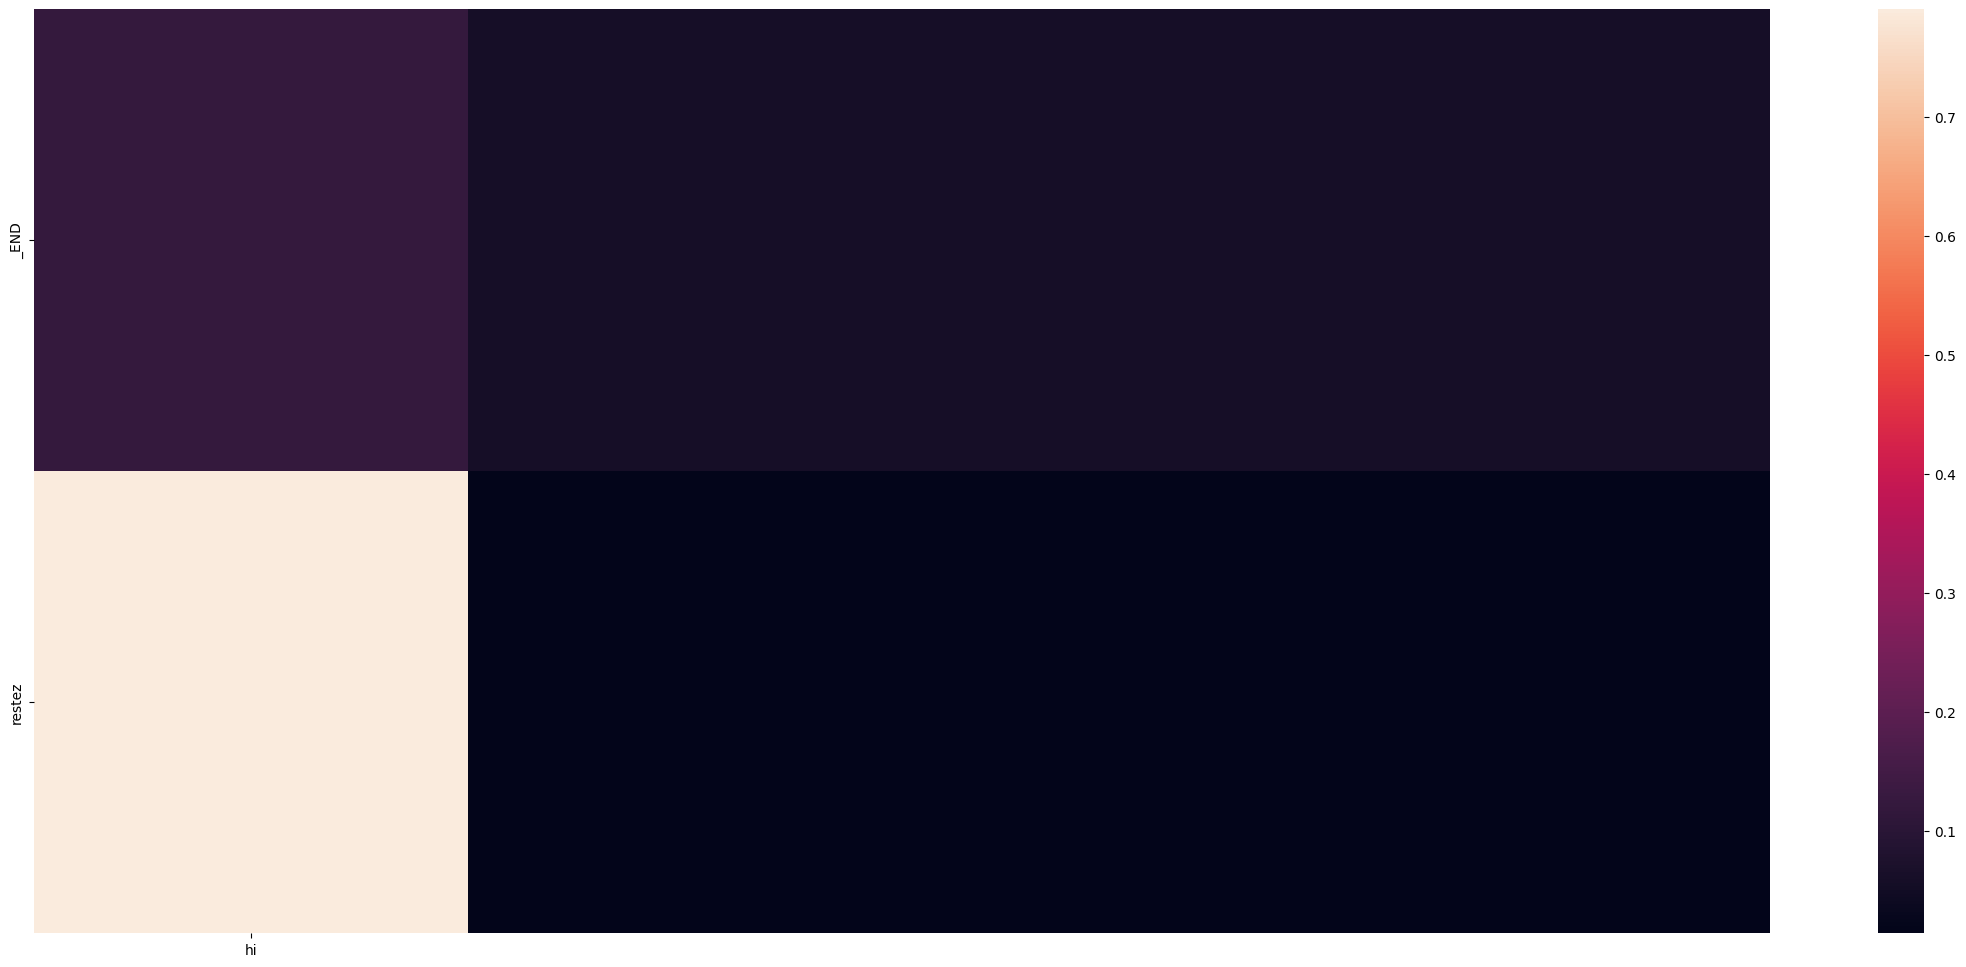

Decoded sentence:  restez _END
-
Input sentence: hi
GT sentence: START_ salut _END
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


<Figure size 640x480 with 0 Axes>

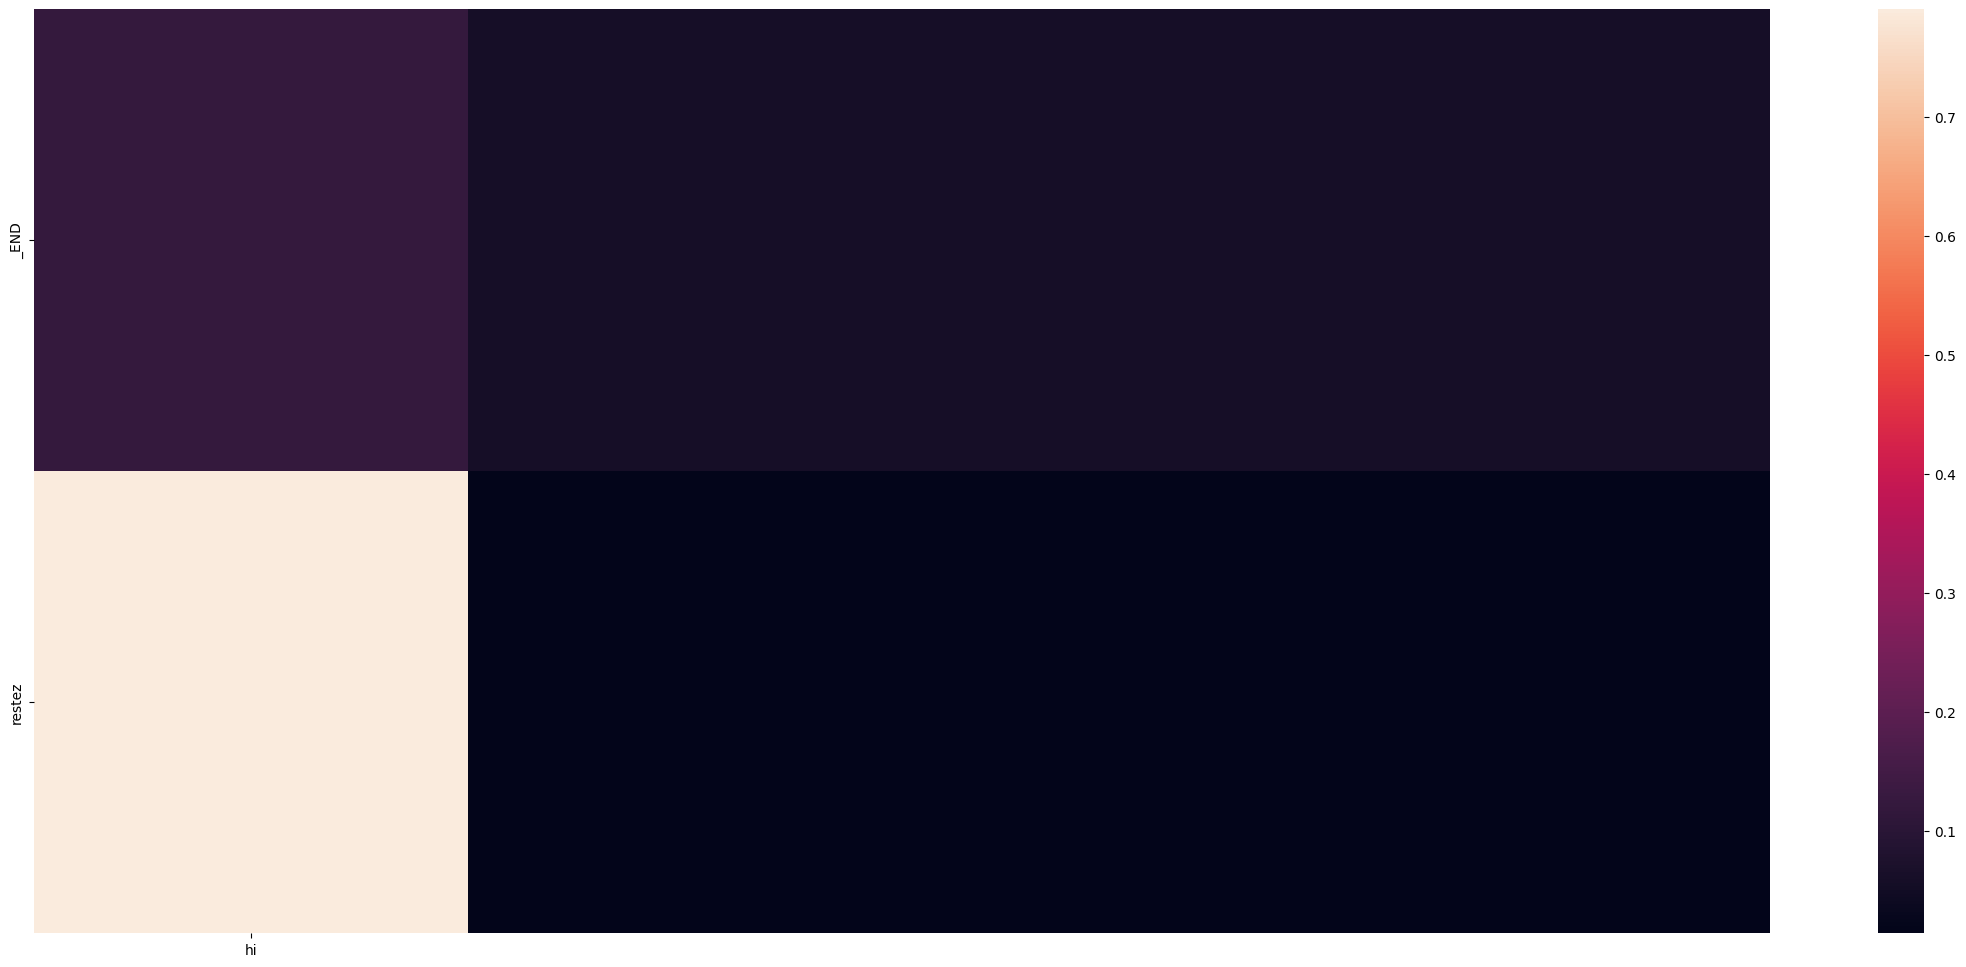

Decoded sentence:  restez _END
-
Input sentence: run
GT sentence: START_ cours  _END
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


<Figure size 640x480 with 0 Axes>

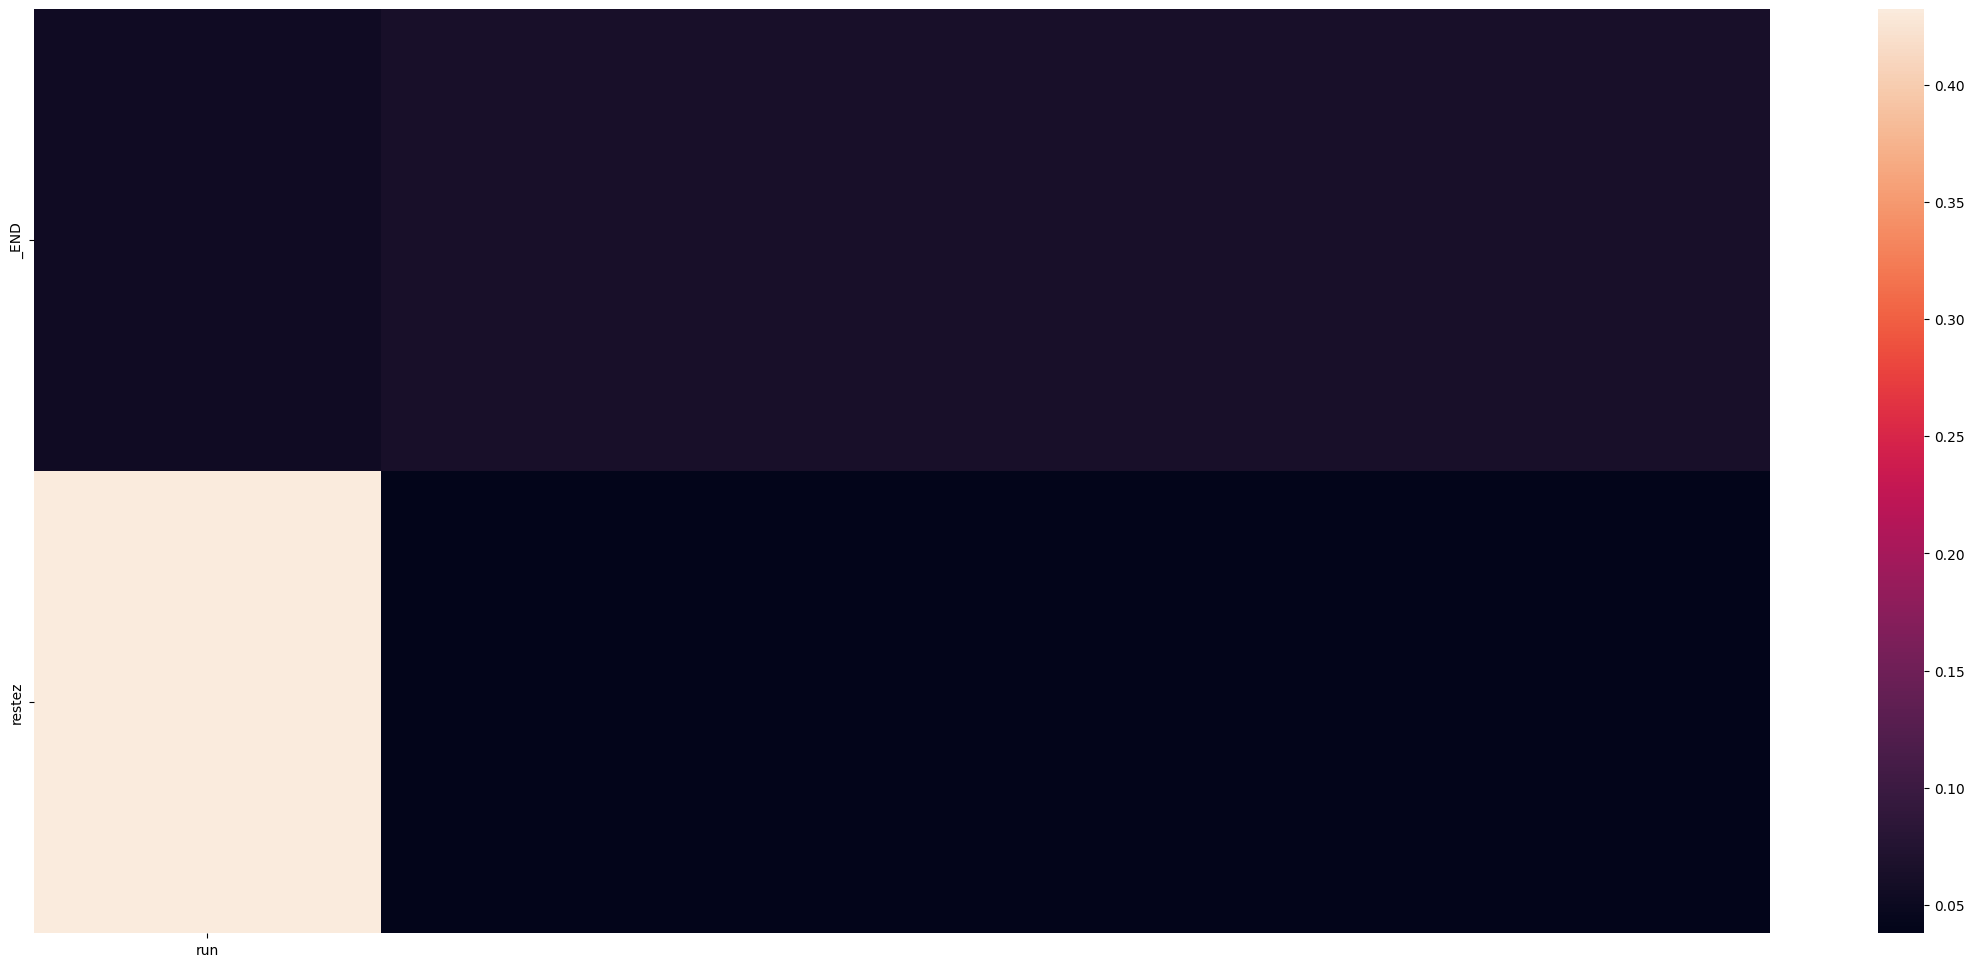

Decoded sentence:  restez _END
-
Input sentence: run
GT sentence: START_ courez  _END
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


<Figure size 640x480 with 0 Axes>

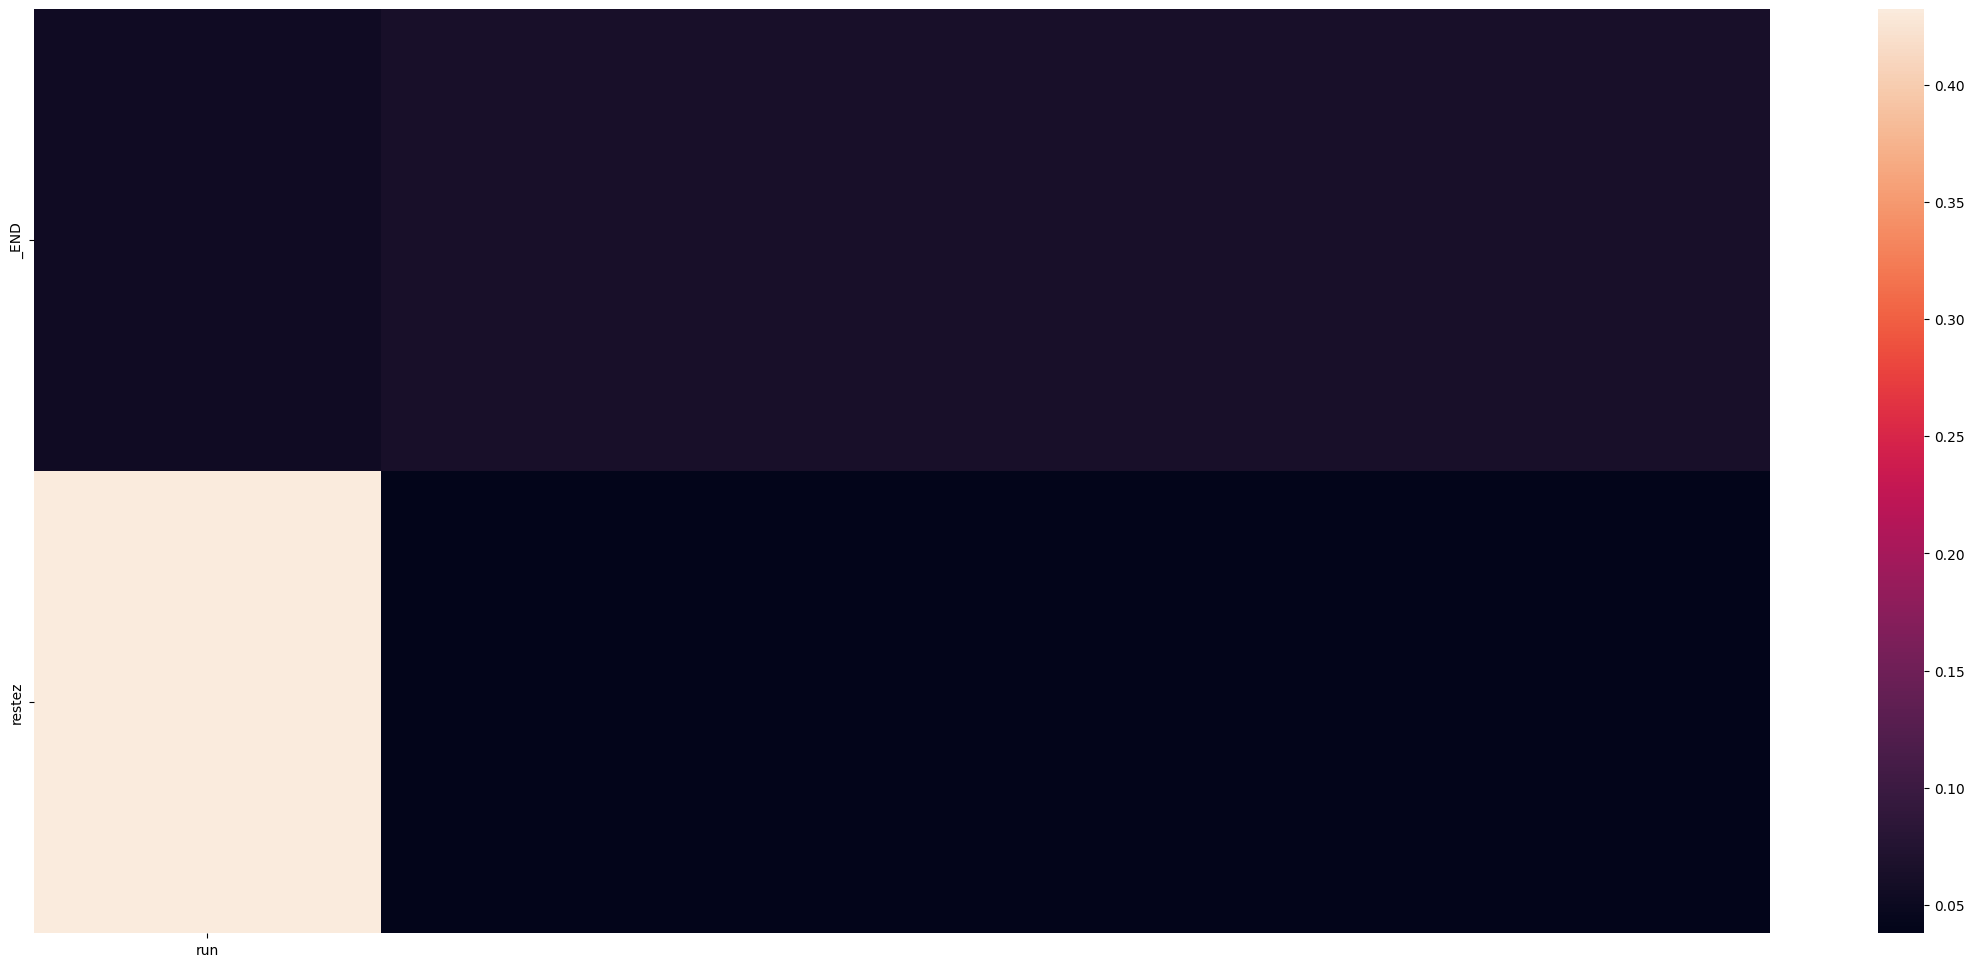

Decoded sentence:  restez _END
-
Input sentence: run
GT sentence: START_ prenez vos jambes à vos cous  _END
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


<Figure size 640x480 with 0 Axes>

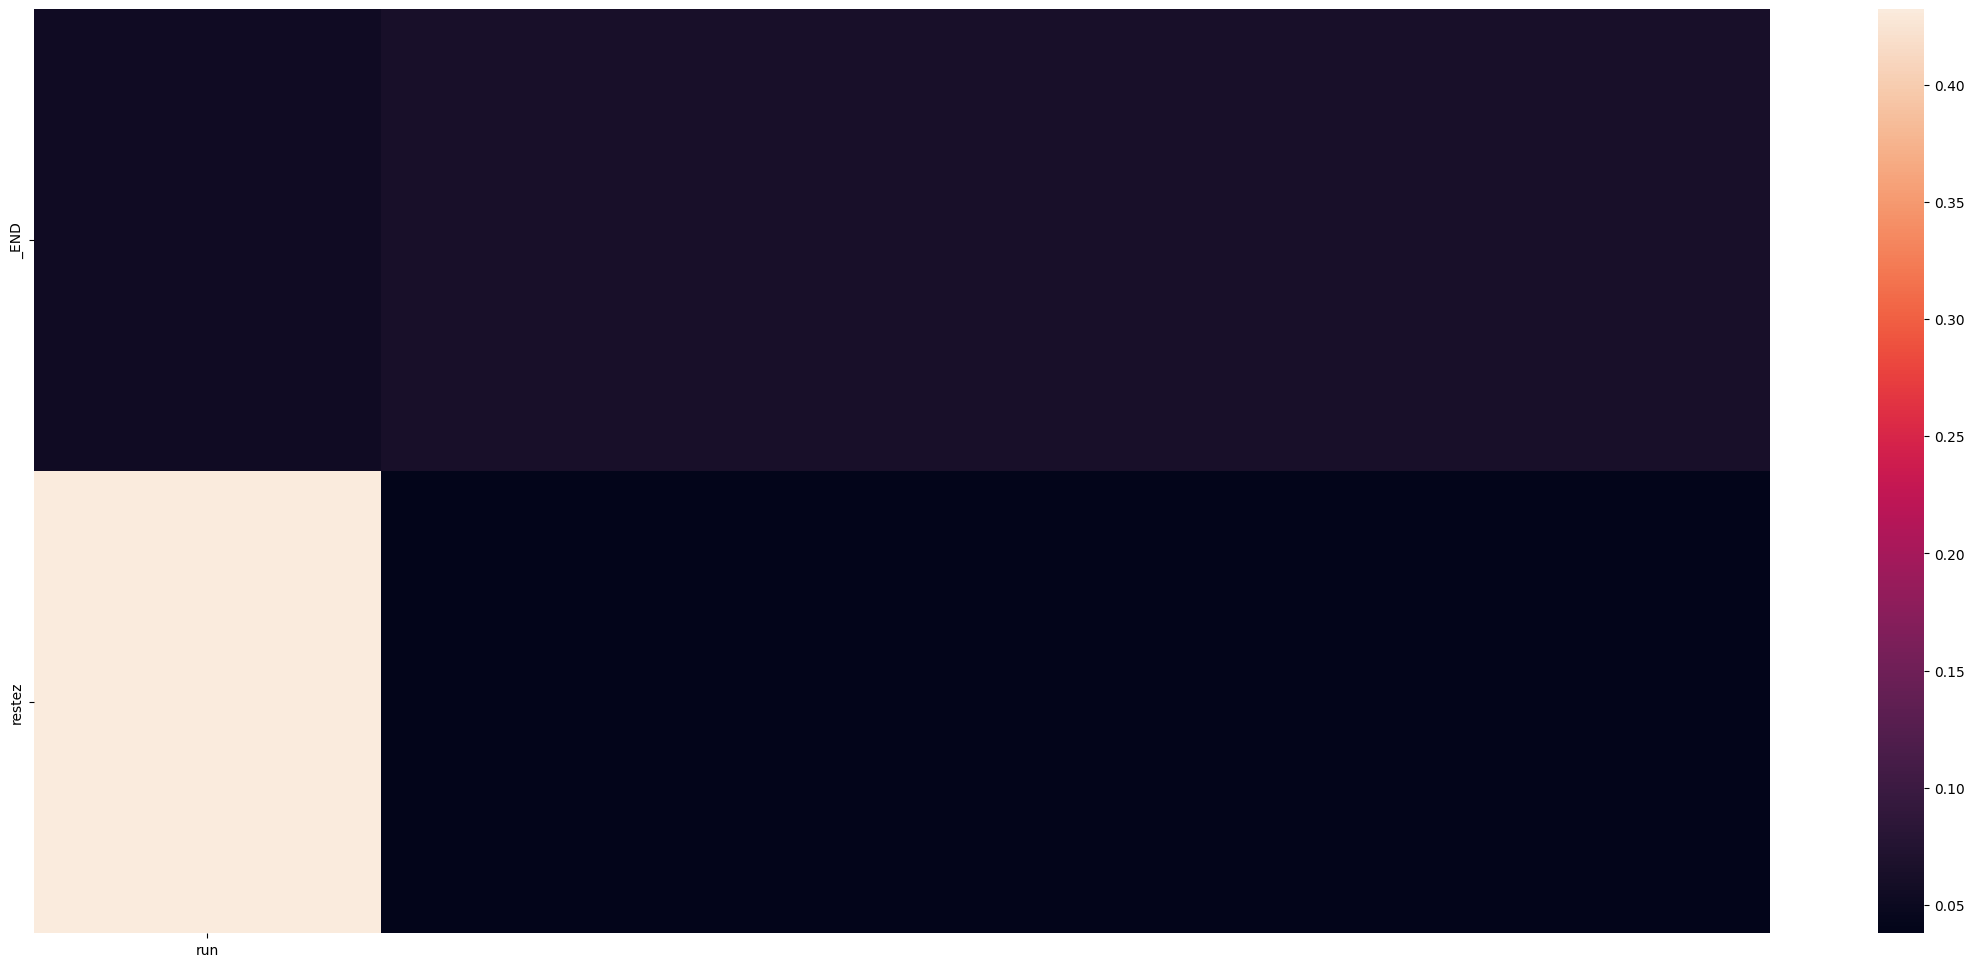

Decoded sentence:  restez _END
-
Input sentence: run
GT sentence: START_ file  _END
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


<Figure size 640x480 with 0 Axes>

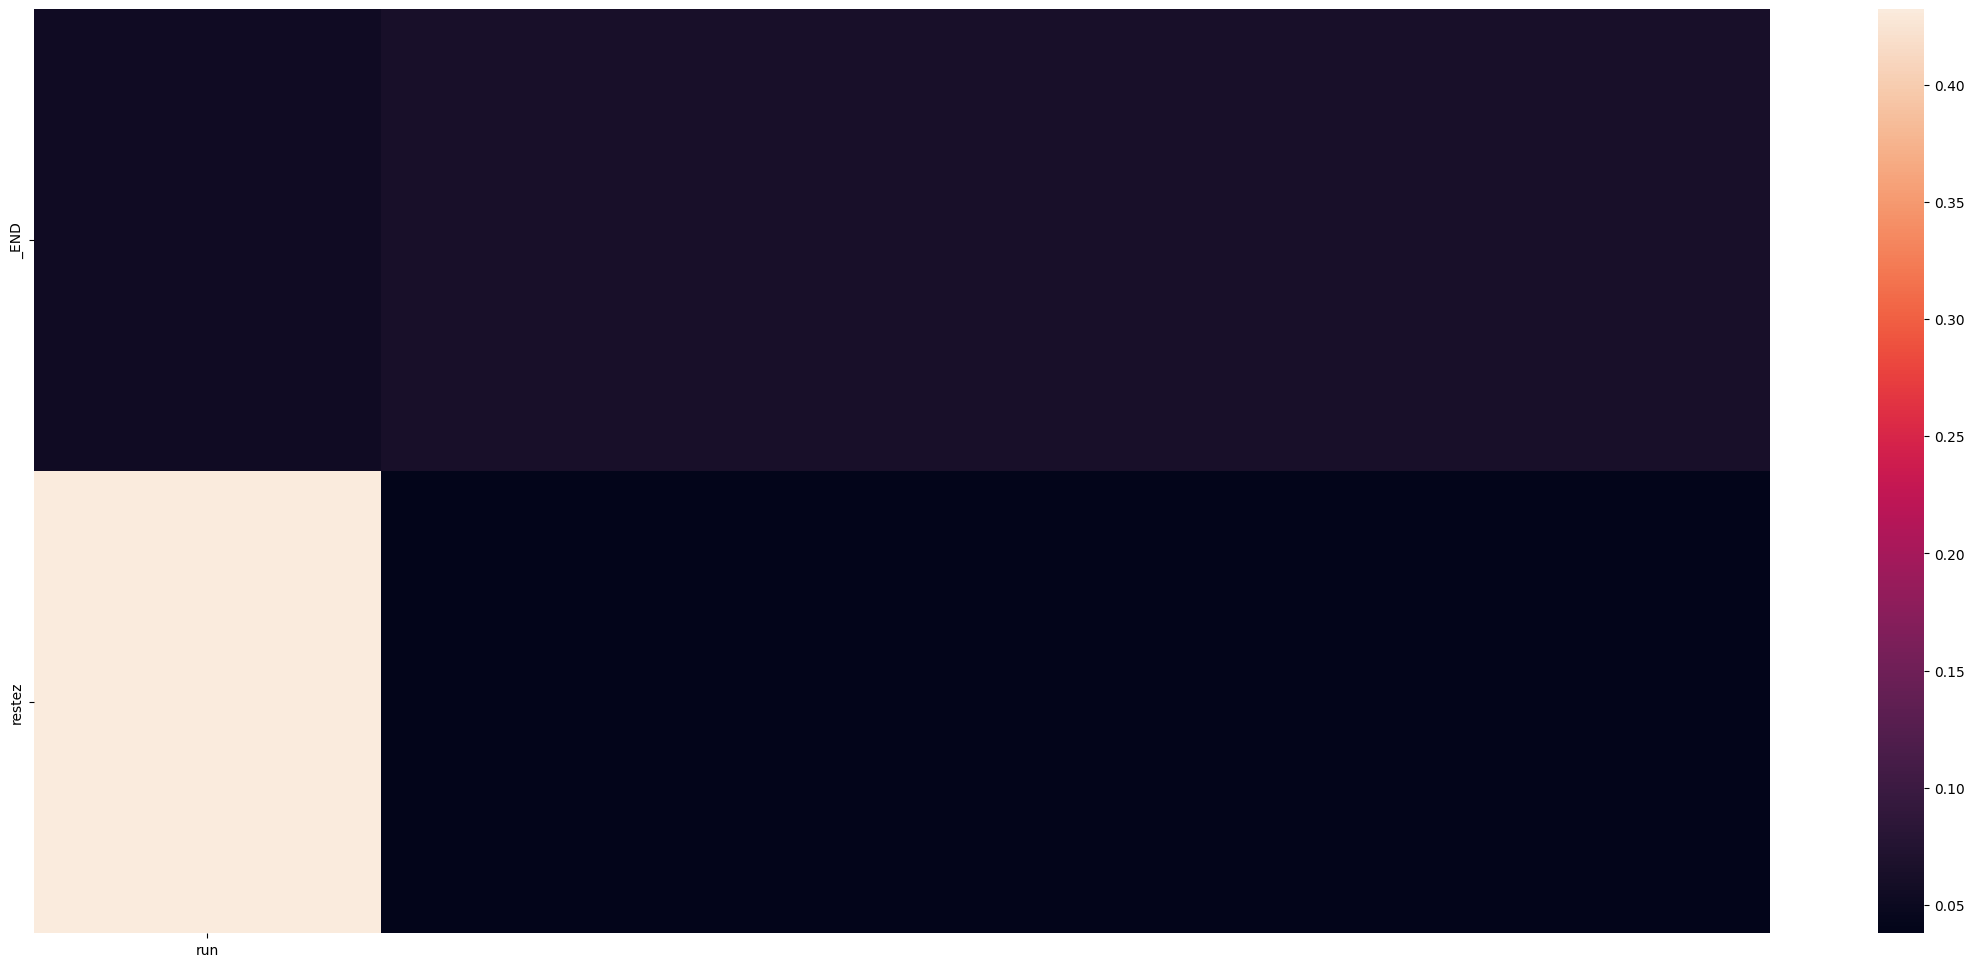

Decoded sentence:  restez _END
-
Input sentence: run
GT sentence: START_ filez  _END
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


<Figure size 640x480 with 0 Axes>

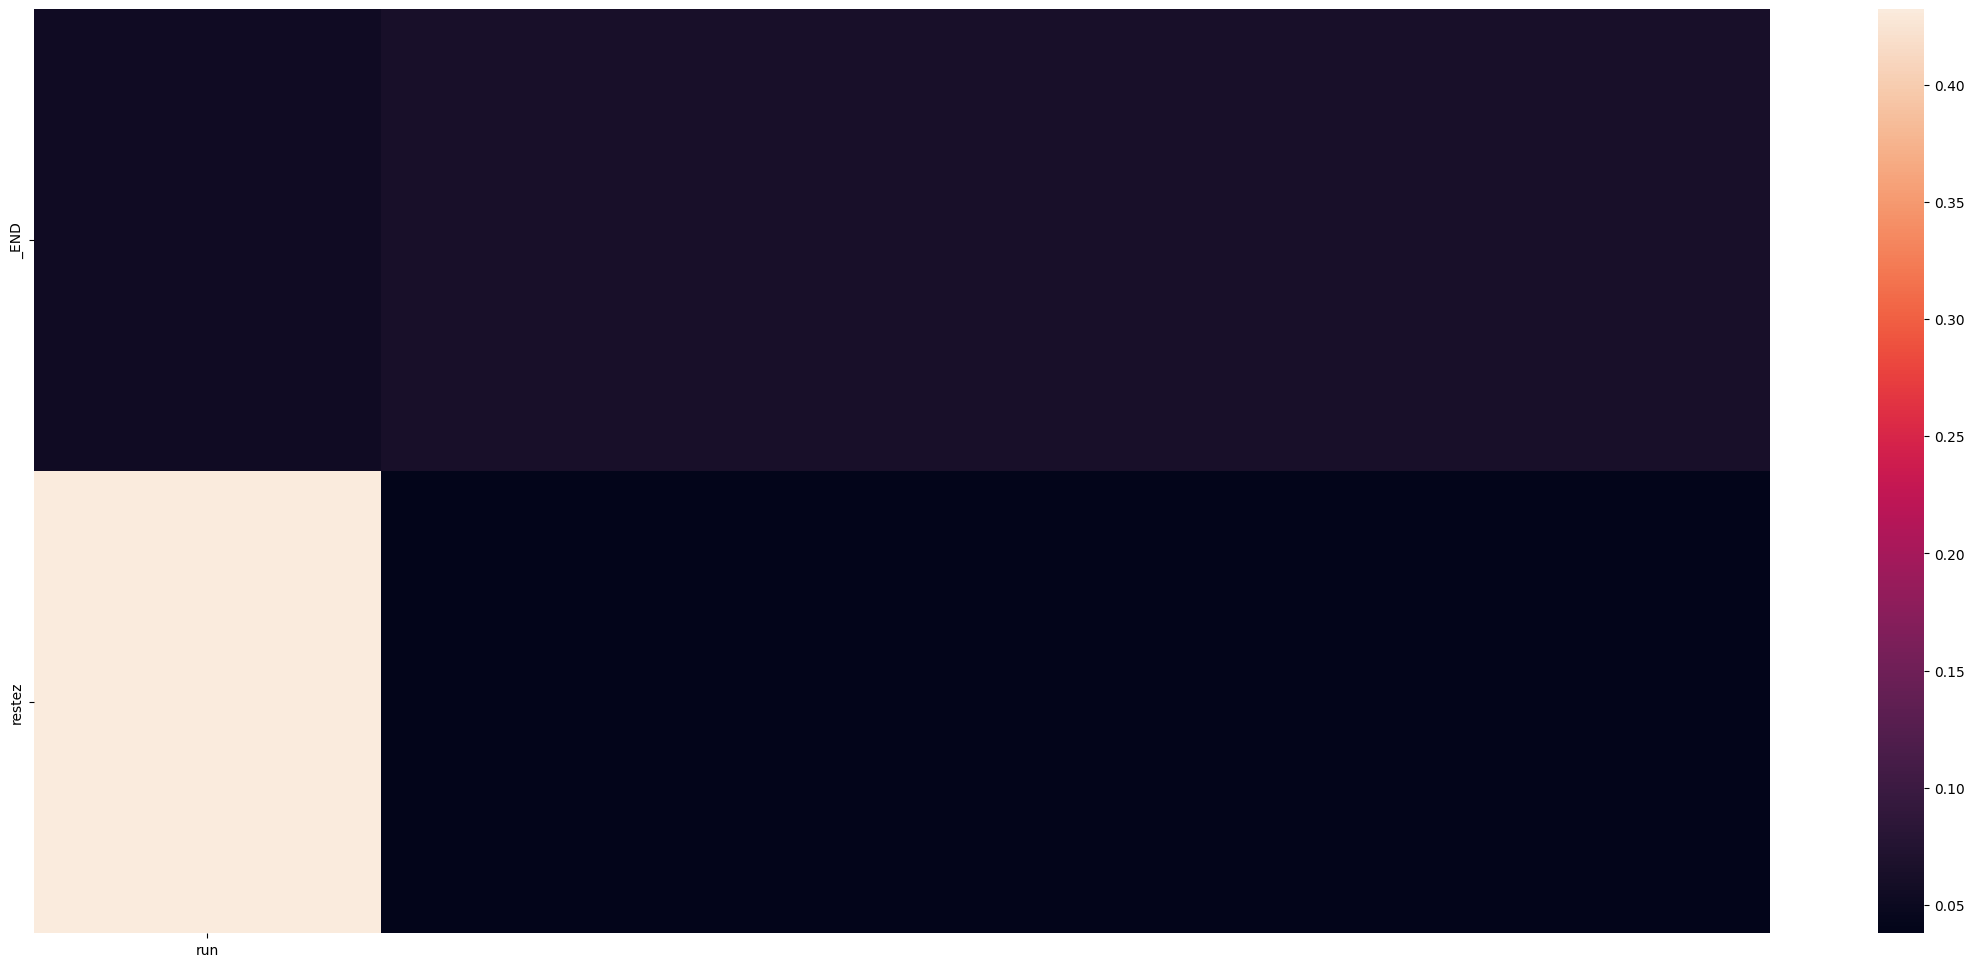

Decoded sentence:  restez _END
-
Input sentence: run
GT sentence: START_ cours  _END
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


<Figure size 640x480 with 0 Axes>

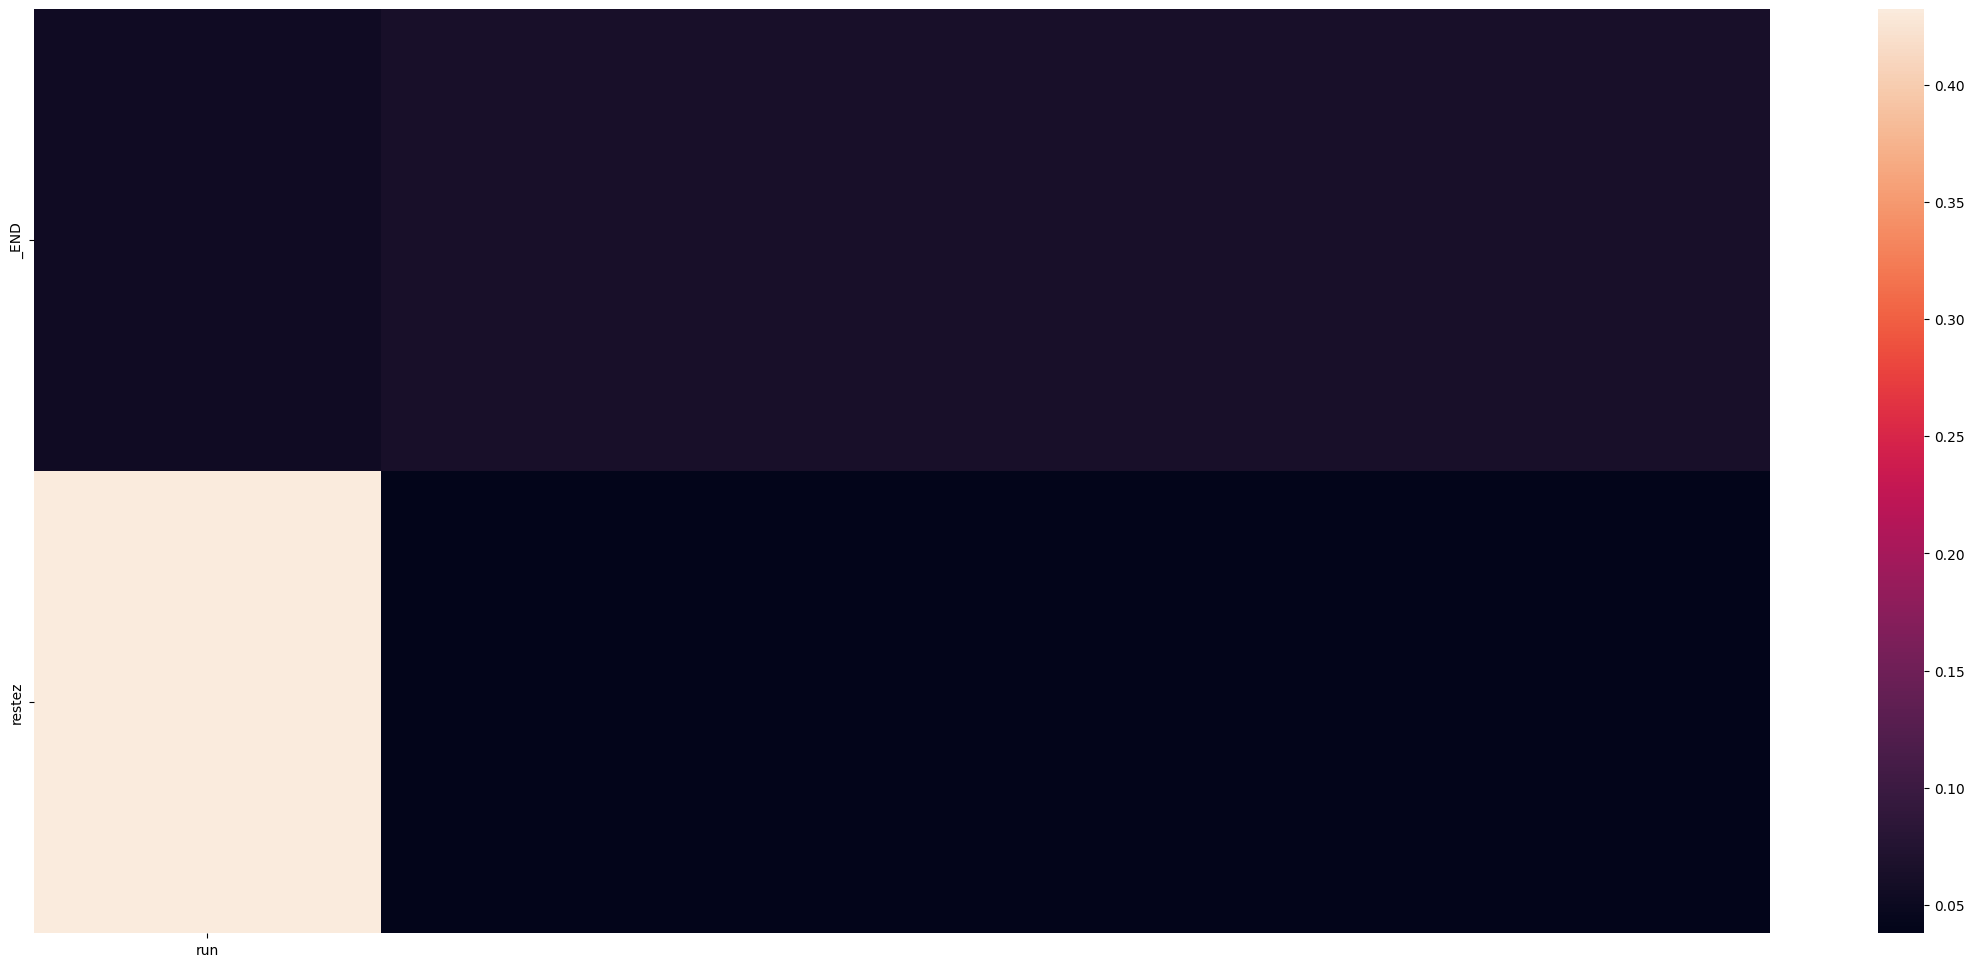

Decoded sentence:  restez _END
-
Input sentence: run
GT sentence: START_ fuyez  _END
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


<Figure size 640x480 with 0 Axes>

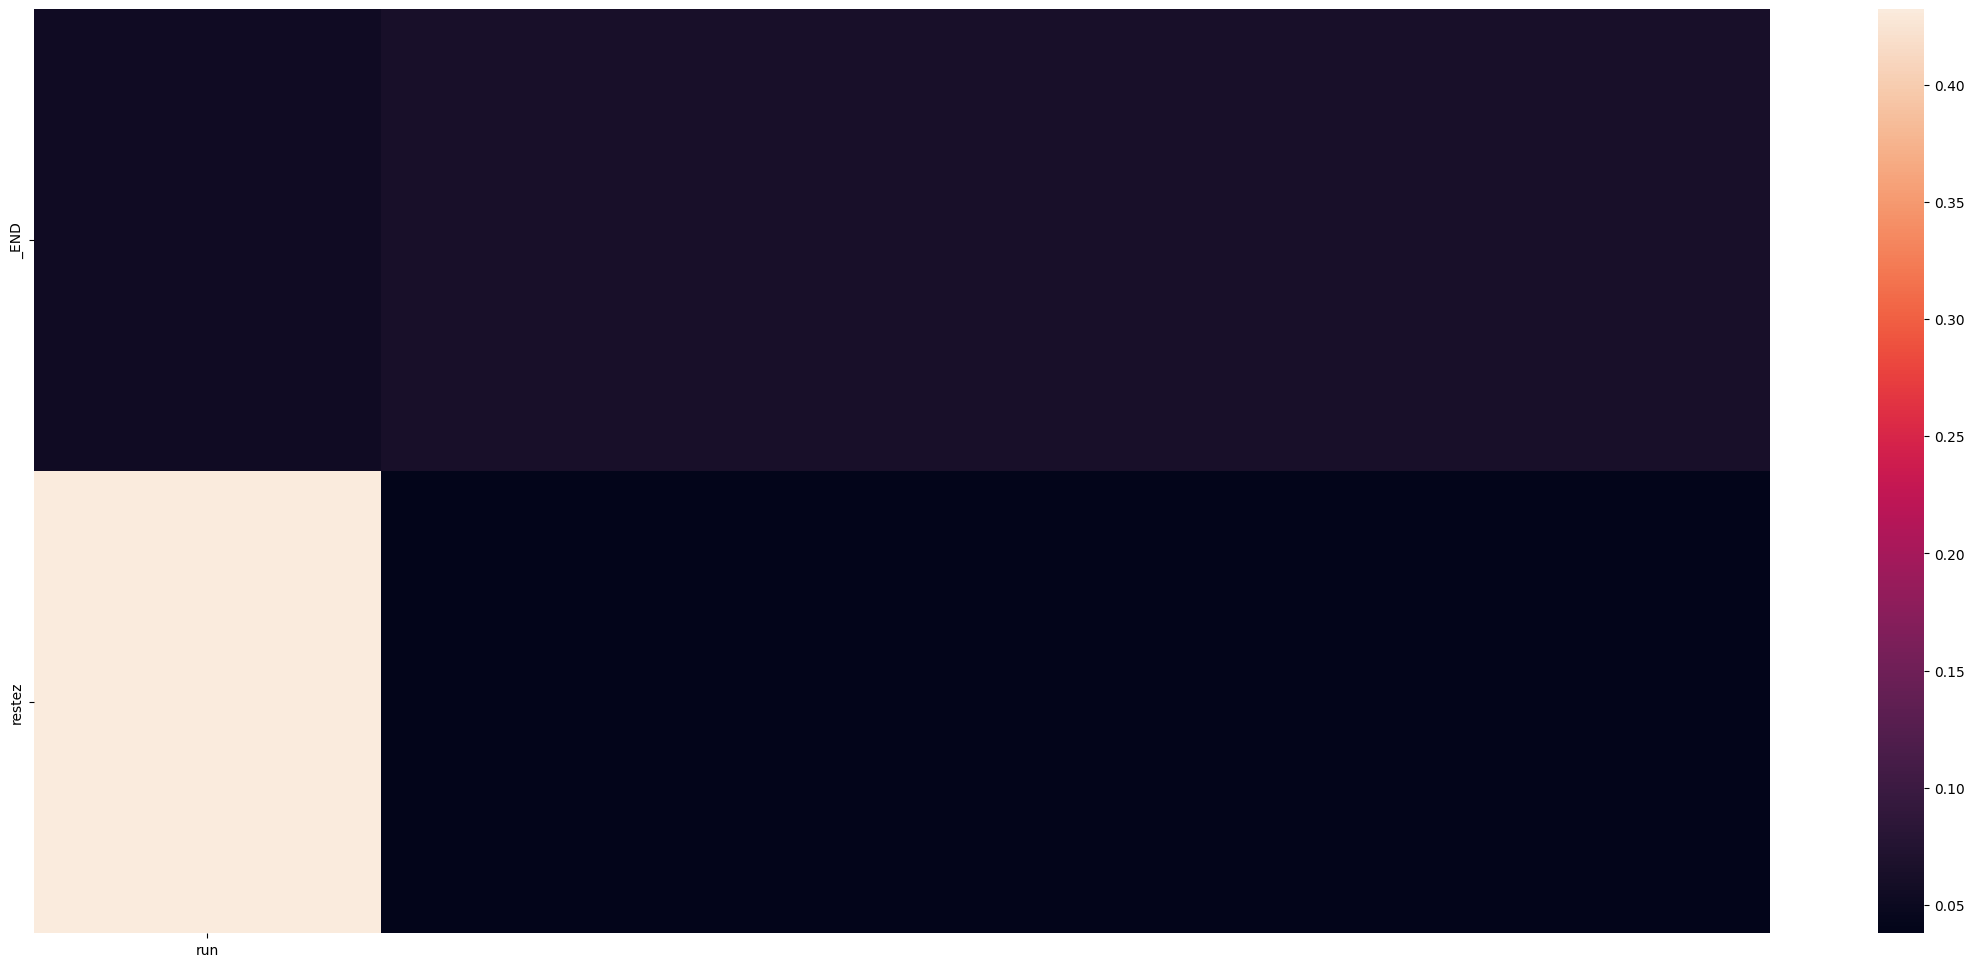

Decoded sentence:  restez _END
-
Input sentence: run
GT sentence: START_ fuyons  _END
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


<Figure size 640x480 with 0 Axes>

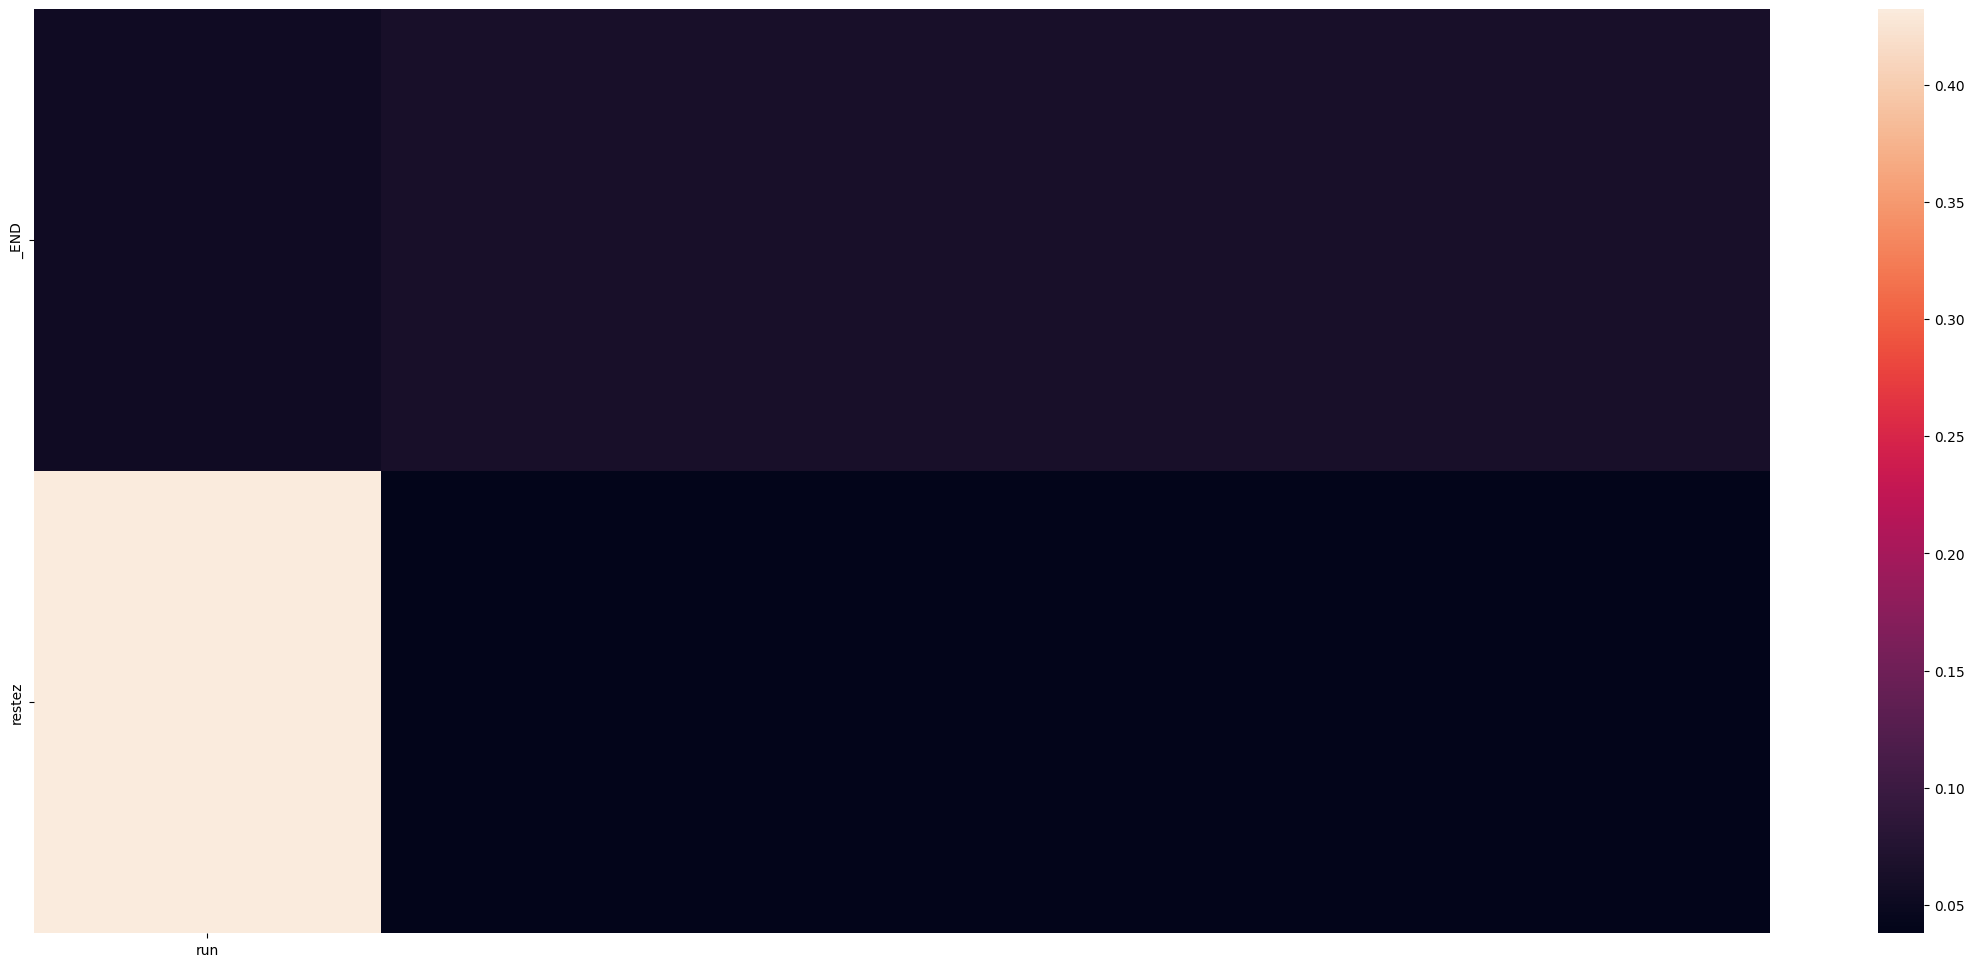

Decoded sentence:  restez _END
-
Input sentence: run
GT sentence: START_ cours  _END
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


<Figure size 640x480 with 0 Axes>

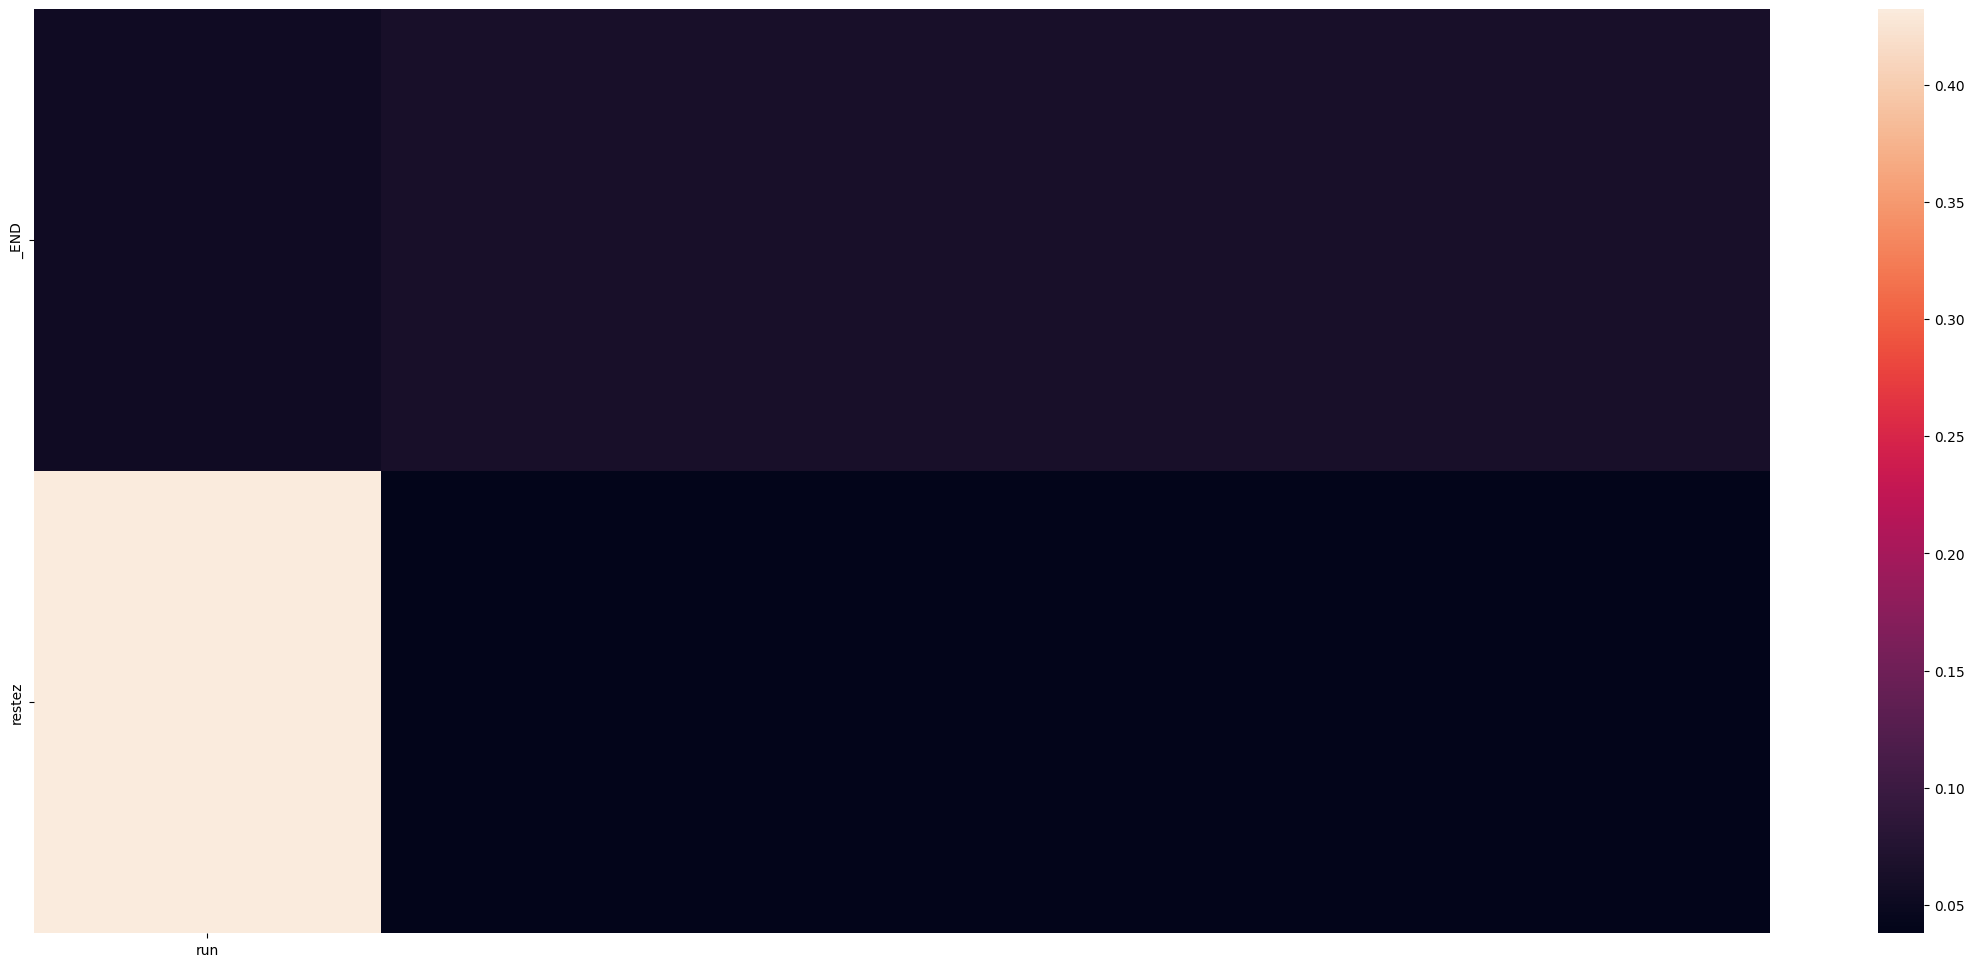

Decoded sentence:  restez _END
-
Input sentence: run
GT sentence: START_ courez  _END
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


<Figure size 640x480 with 0 Axes>

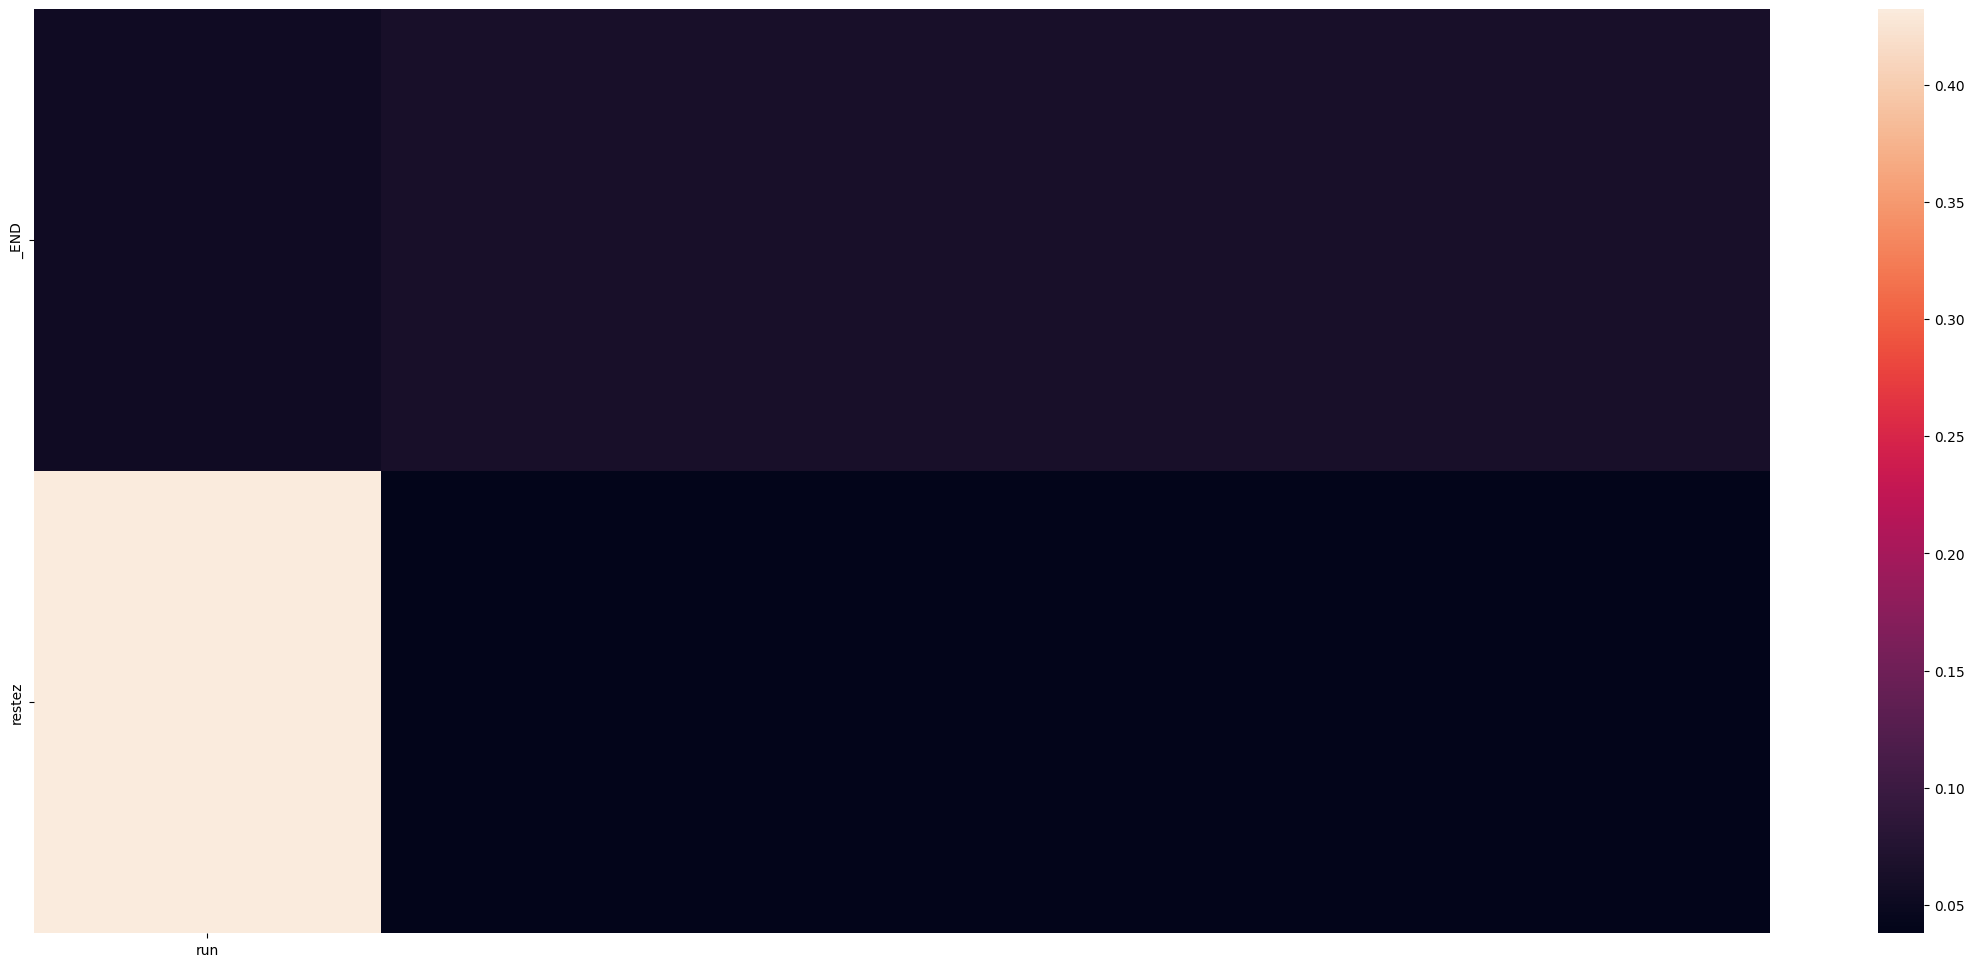

Decoded sentence:  restez _END
-
Input sentence: run
GT sentence: START_ prenez vos jambes à vos cous  _END
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


<Figure size 640x480 with 0 Axes>

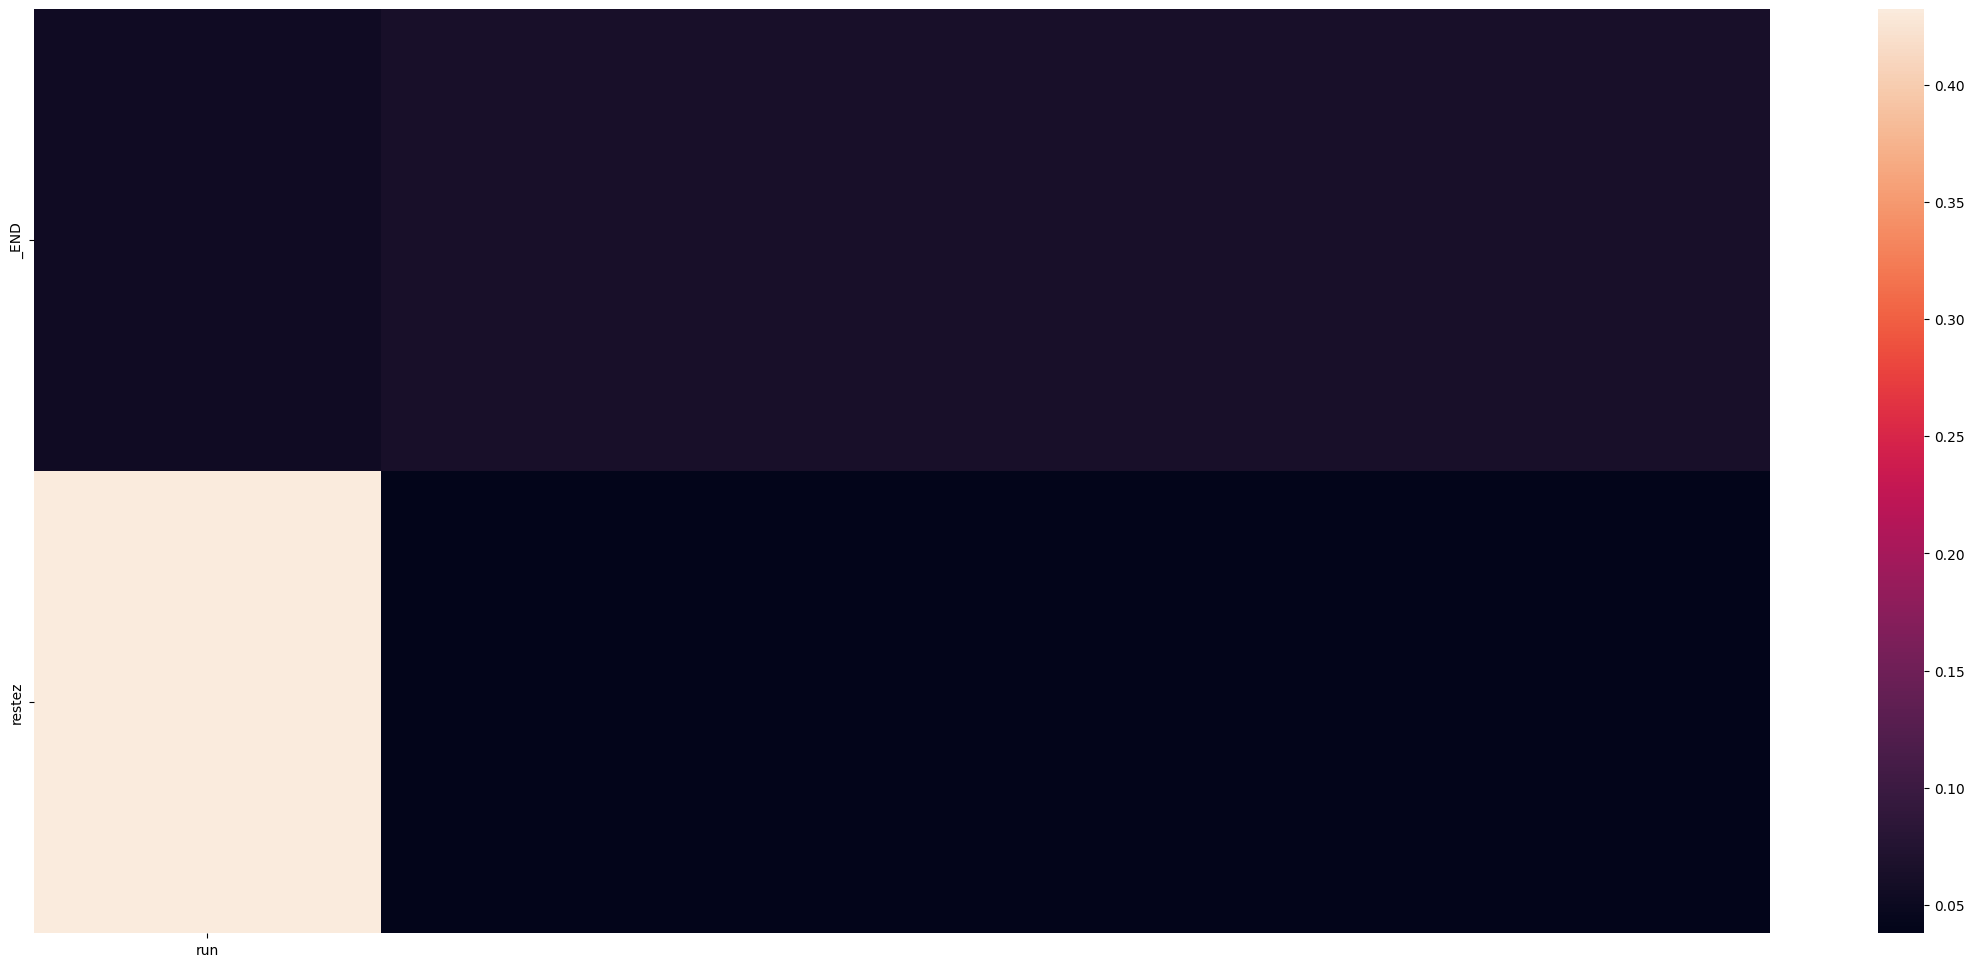

Decoded sentence:  restez _END
-
Input sentence: run
GT sentence: START_ file  _END
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


<Figure size 640x480 with 0 Axes>

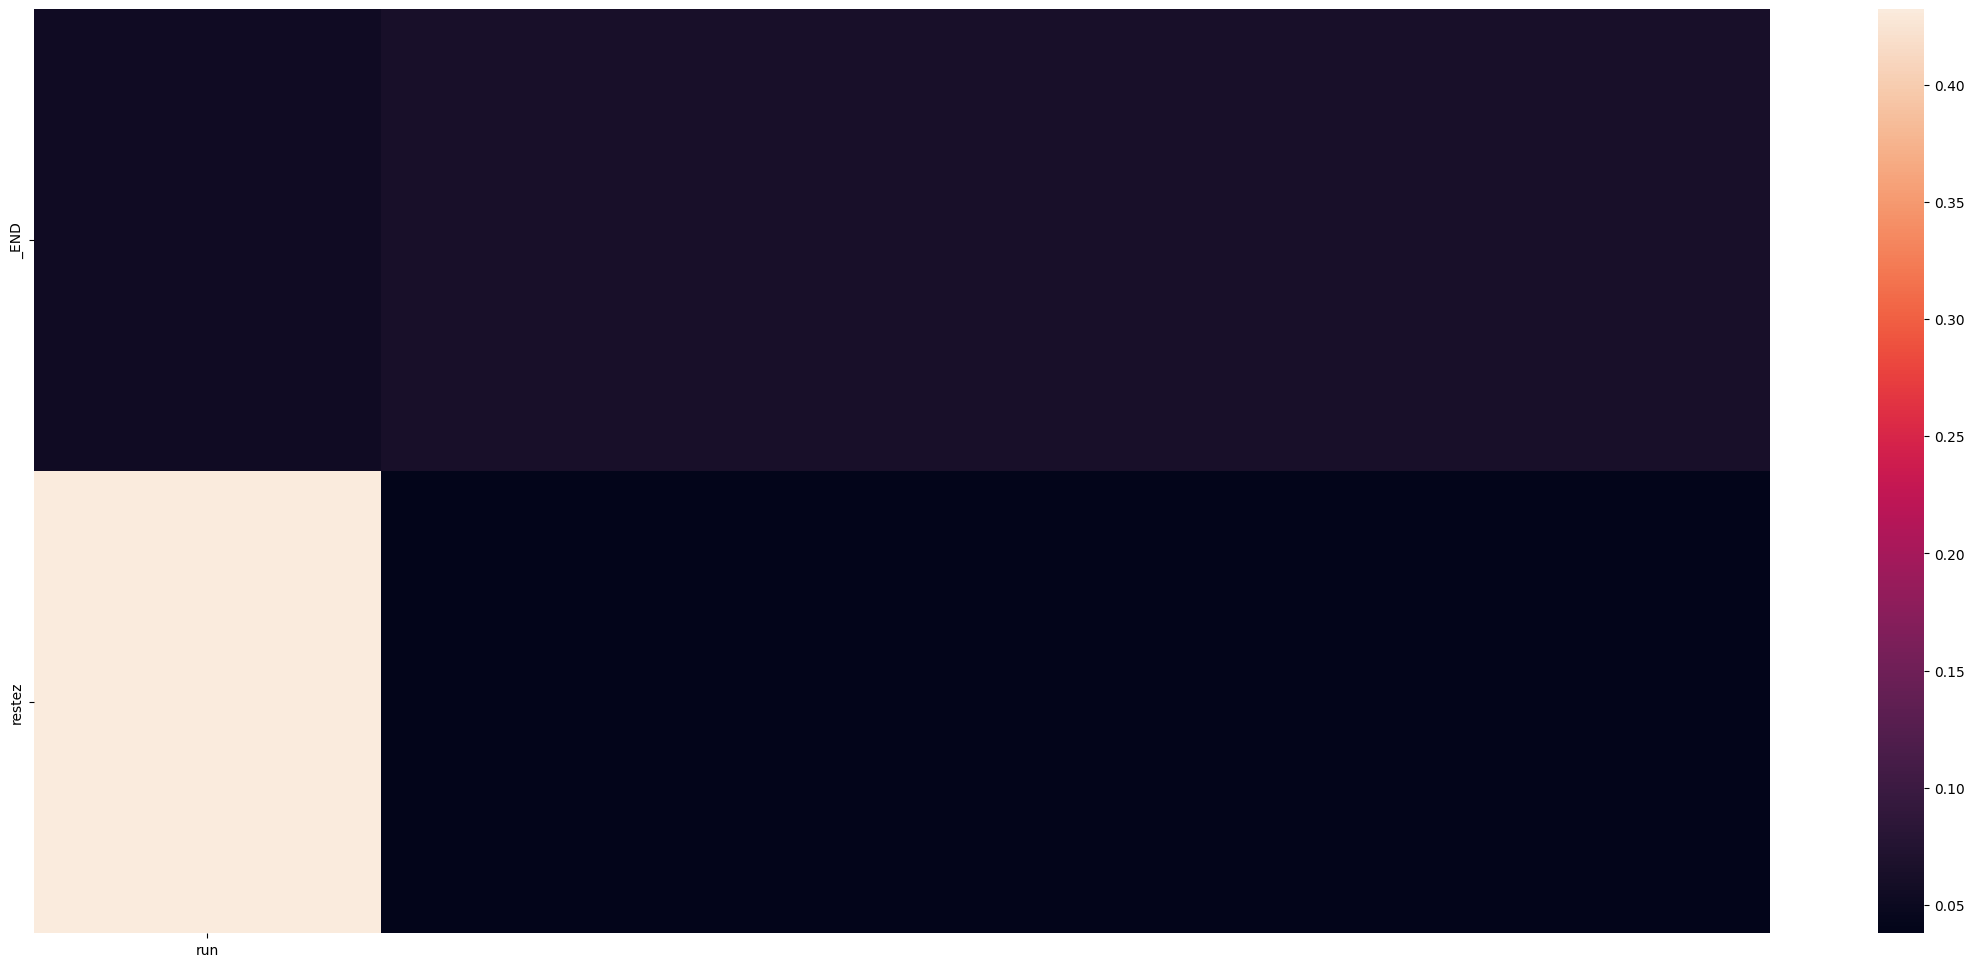

Decoded sentence:  restez _END
-
Input sentence: run
GT sentence: START_ filez  _END
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


<Figure size 640x480 with 0 Axes>

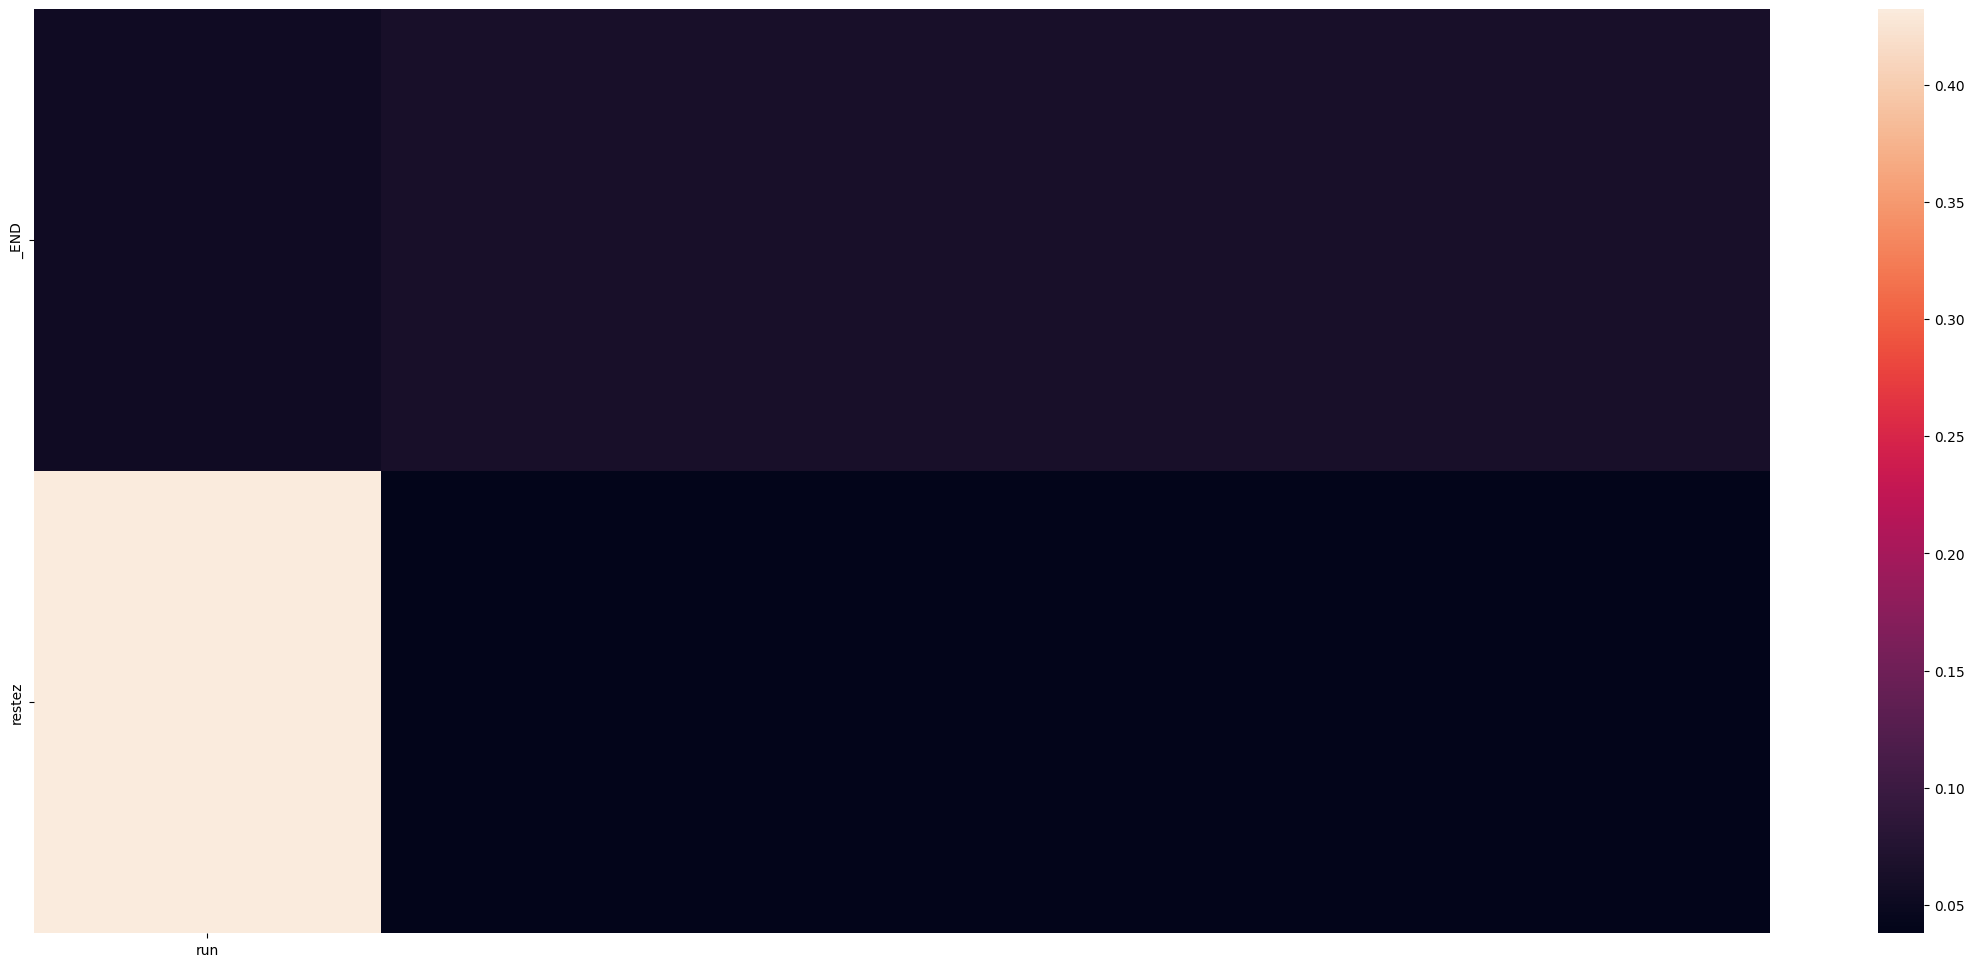

Decoded sentence:  restez _END
-
Input sentence: run
GT sentence: START_ cours  _END
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


<Figure size 640x480 with 0 Axes>

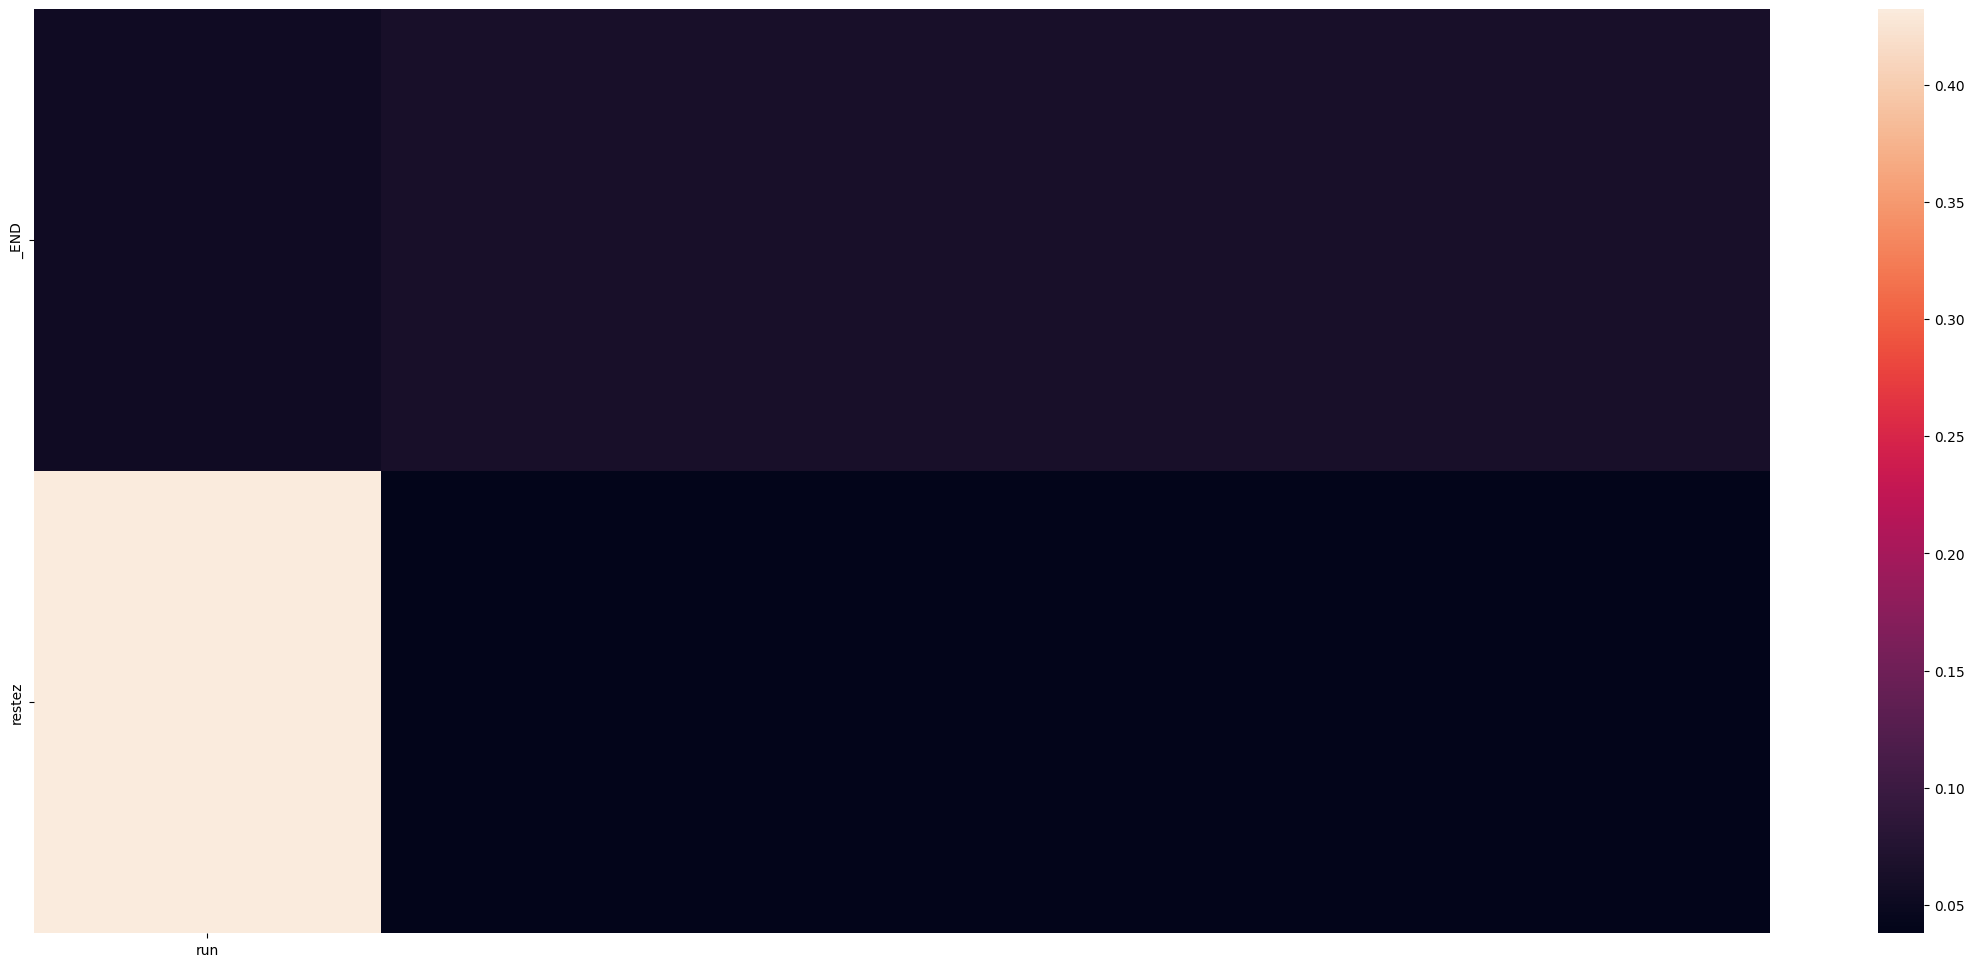

Decoded sentence:  restez _END


In [26]:
for seq_index in range(20):

    target_text = lines.target[seq_index]
    text = lines.input[seq_index]
    print('-')
    print('Input sentence:', text)
    print('GT sentence:', target_text)
    decoded_sentence = visualize_attention(text, encoder_model, decoder_model, max_encoder_seq_length, num_decoder_tokens, input_token_index, reverse_target_tok_index, tok_split_word2word)


    print('Decoded sentence:', decoded_sentence)
